# An integrated diagnostic analysis of plasma waves

## Setup
Identify time ranges into which to separate the analysis. Locate crash times and define widows just before and just after them. Various plots shown to indicate suitability of ranges and windows.


Import necessary packages

In [1]:
from lib.imports_BES import *
#from lib.functions_BES import *
from lib.analysis_functions_BES import *
from lib.analysis_functions_Mirnov import *
from lib.plotting_functions_BES import *
from lib.analysis_functions_general import *

Load BES data from various NETCDF files

In [2]:
# Specify path to where data is stored
bes_data_path = "BES_code_local/Data/"
shot = 29378
shotlabel = "\#" + str(shot)

# Dalpha data. Array for time and array for values
dalpha_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_dalpha.nc")
dalpha_time = np.asarray(dalpha_from_file.coords['time'])
dalpha_data = np.asarray(dalpha_from_file)

# Upper tangential Dalpha. Array for time and array for values
utda_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_upper_tan_dalpha.nc")
utda_time = np.asarray(utda_from_file.coords['time'])
utda_data = np.asarray(utda_from_file)

# Line-averaged density. Array for time and array for values
density_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_density.nc")
density_time = np.asarray(density_from_file.coords['time'])
density_data = np.asarray(density_from_file)

# Equilibria from EFIT. Two spacial arrays, a time array and 2D array of psi
equilib_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_equilibria.nc")
equilib_time = np.asarray(equilib_from_file.coords['time'])
equilib_R = np.asarray(equilib_from_file.coords['R'])
equilib_Z = np.asarray(equilib_from_file.coords['Z'])
equilib_psi = np.asarray(equilib_from_file)

# (R, z) locations for the BES channels. Shape: (32,2)
apdpos = np.asarray(xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_apdpos.nc"))

# Main BES data. Array for times and shape (32,time) array for fluctuation
fluct_data_from_file = xr.open_dataarray(bes_data_path + "shot" + str(shot) + "_LH_fluct_data.nc")
bes_time = np.asarray(fluct_data_from_file.coords['time'])
fluct_data = np.asarray(fluct_data_from_file)

Load Mirnov coil data

In [3]:
mirnov_data_path = "Mirnov_code_local/Data/"

# Get coil positions
coilpos = np.asarray(xr.open_dataarray(mirnov_data_path + "coil_positions.nc"))

# Main Mirnov data
mirnov_data_from_file = xr.open_dataarray(mirnov_data_path + "shot" + str(shot) + "_mirnov_data.nc")
mirnov_time = np.asarray(mirnov_data_from_file.coords['time'])
coil_nums = np.asarray(mirnov_data_from_file.coords['coil']) # Coil numbers e.g. 210 for coils in order of data
mirnov_data = np.asarray(mirnov_data_from_file) # Shape (11,650000)

# Useful coils appear to be [206, 207, 210, 212, 213, 214]
coil_nums = coil_nums[1:7]
mirnov_data = mirnov_data[1:7]
#for i in range(len(mirnov_data)):
#    mirnov_data[i] = mirnov_data[i]/np.std(mirnov_data[i])
coilpos = coilpos[1:7]

Plot $D_\alpha$ data to identify times of interest then input ranges to separate analysis into. Change these as needed

In [4]:
# Change regions' bounds as needed
regions = [[0.16,0.24], [0.36,0.54], [0.54,0.68]]

# BES time is limited to ~0.65
for i in range(len(regions)):
    if regions[i][1] > bes_time[-1]:
        print("Region", i, "trimmed", str(regions[i]), "to", np.around([regions[i][0], bes_time[-1]],2))
        regions[i] = [regions[i][0], bes_time[-1]]

Region 2 trimmed [0.54, 0.68] to [0.54 0.65]


Plot regions so time ranges can be fine-tuned.

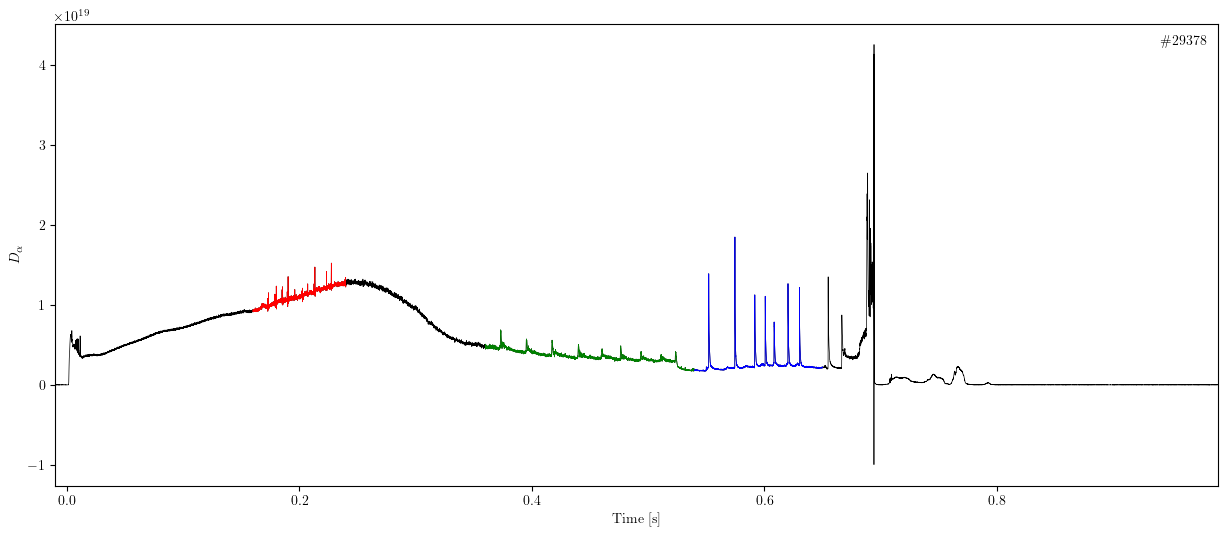

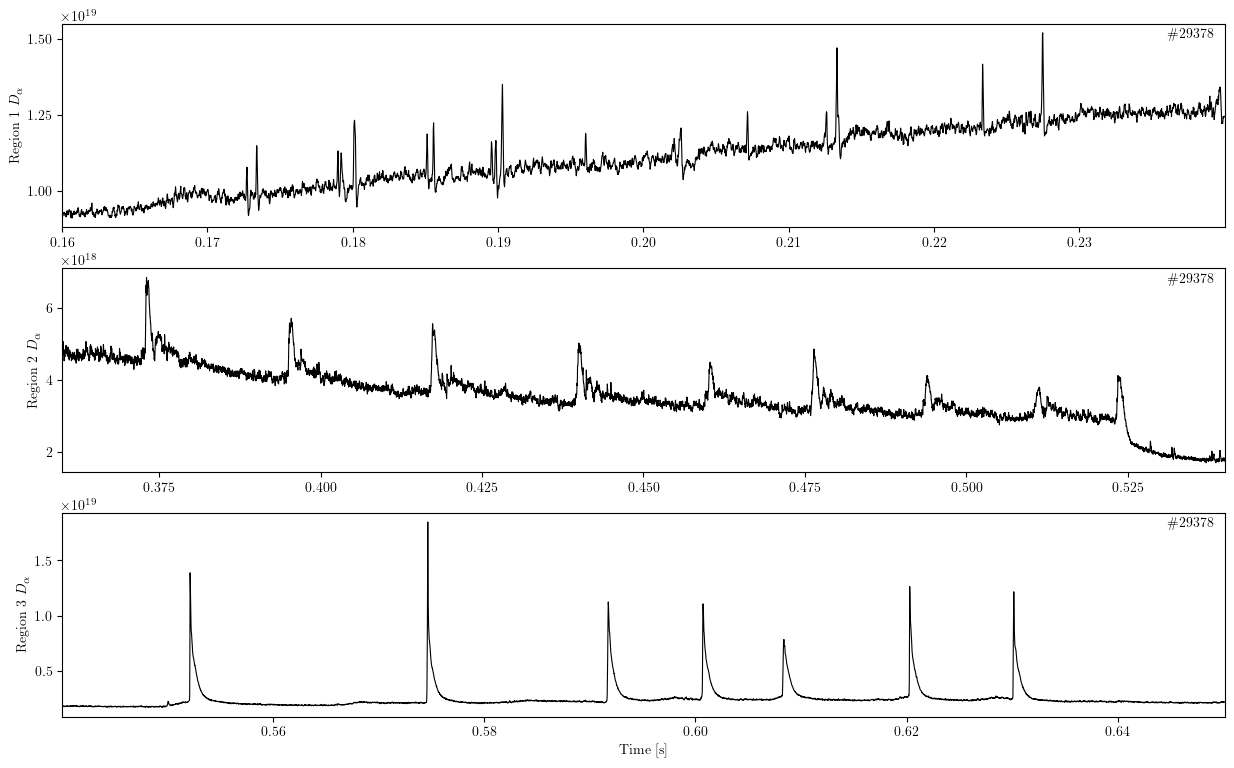

In [5]:
if True:
    colours = ["r", "g", "b", "c", "m", "y"] # Each region plotted in different colour
    
    # Big plot of Dalpha with regions differently colours
    fig1, ax1 = plt.subplots(1, 1, figsize=(15, 6))
    ax1.plot(dalpha_time, dalpha_data, 'k', linewidth=0.5)

    # Plots of each region separately
    fig2, ax2 = plt.subplots(len(regions), 1, sharex=False, figsize=(15, 9))

    for i in range(len(regions)):
        idx1 = (np.abs(dalpha_time - regions[i][0])).argmin()
        idx2 = (np.abs(dalpha_time - regions[i][1])).argmin()
        ax1.plot(dalpha_time[idx1:idx2+1], dalpha_data[idx1:idx2+1], colours[i], linewidth=0.5)

        ax2[i].plot(dalpha_time[idx1:idx2], dalpha_data[idx1:idx2], 'k', linewidth=0.8)
        ax2[i].tick_params(axis='x')
        ax2[i].tick_params(axis='y')
        ax2[i].set_ylabel(r"Region " + str(i+1) + r" $D_\alpha$")
        ax2[i].locator_params(axis='y', nbins=3)
        ax2[i].set_xlim([dalpha_time[idx1], dalpha_time[idx2]])
        ax2[i].text(.99, .975, shotlabel, ha='right', va='top', transform=ax2[i].transAxes)

    ax1.set_xlabel("Time [s]")
    ax1.set_ylabel(r"$D_\alpha$")
    ax1.set_xlim([dalpha_time[0], dalpha_time[-1]])
    ax1.text(.99, .975, shotlabel, ha='right', va='top', transform=ax1.transAxes)

    ax2[-1].set_xlabel("Time [s]")

    #fig1.savefig("Full_Dalpha_plot.pdf", format="pdf", bbox_inches="tight")
    #fig2.savefig("Dalpha_region_plots.pdf", format="pdf", bbox_inches="tight")

    plt.show()
    plt.close()

Now use tangential $D_\alpha$ data to identify crash times. Set threshold for each region so that the blue line runs below most of the peaks while avoiding baseline noise.

In [6]:
thresholds = [0.04, 0.008, 0.02]
if False:
    figure, axes = plt.subplots(len(regions), 1, sharex=False, figsize=(15, 9))

    for i in range(len(regions)):
        idx1 = (np.abs(utda_time - regions[i][0])).argmin()
        idx2 = (np.abs(utda_time - regions[i][1])).argmin()

        axes[i].plot(utda_time[idx1:idx2], np.gradient(utda_data[idx1:idx2]), "k", linewidth=0.5)
        axes[i].hlines(thresholds[i], utda_time[idx1], utda_time[idx2], linewidth=0.5)
        axes[i].set_ylabel("Region " + str(i+1))
        axes[i].locator_params(axis="y", nbins=7)
        axes[i].text(.99, .975, shotlabel, ha='right', va='top', transform=axes[i].transAxes)
        axes[i].set_xlim([utda_time[idx1], utda_time[idx2]])

    axes[-1].set_xlabel("Time [s]")
    axes[0].set_title(r"Upper tangential $D_\alpha$ derivative")
    plt.subplots_adjust(hspace=0.5)

    plt.show()
    plt.close()

Using thresholds defined above, find windows around crashes

Change start/end shifts as needed

In [7]:
pre_crash_windows = {}
post_crash_windows = {}
crash_times = {}
for region in range(len(regions)):
    crash_times[region] = get_crash_times(utda_time, utda_data, thresholds[region], regions[region])
    pre_crash_windows[region] = get_crash_adjacent_window(utda_time, utda_data, thresholds[region], regions[region], start_shift=5e-3, end_shift=1e-3)
    post_crash_windows[region] = get_crash_adjacent_window(utda_time, utda_data, thresholds[region], regions[region], start_shift=-1e-3, end_shift=-5e-3)

Make some plots to check that windows found are sensible, readjust above as needed

In [8]:
if False:
    # Plots of each region separately with found crashes marked
    fig, ax = plt.subplots(len(regions), 1, sharex=False, figsize=(15, 3*len(regions)))

    for i in range(len(regions)):
        idx1 = (np.abs(dalpha_time - regions[i][0])).argmin()
        idx2 = (np.abs(dalpha_time - regions[i][1])).argmin()

        ax[i].plot(dalpha_time[idx1:idx2], dalpha_data[idx1:idx2], 'k', linewidth=0.8)
        ax[i].text(.99, .975, shotlabel, ha='right', va='top', transform=ax[i].transAxes)
        
        for peak in crash_times[i]:
            crash_amplitude = dalpha_data[(np.abs(dalpha_time - peak)).argmin()]
            ax[i].scatter(peak, crash_amplitude, marker="x")

        for pre_window in pre_crash_windows[i]:
            #ax[i].vlines(pre_window[0], np.min(dalpha_data[idx1:idx2]), np.max(dalpha_data[idx1:idx2]), "g", linestyle="dashed", linewidth=0.5)
            #ax[i].vlines(pre_window[1], np.min(dalpha_data[idx1:idx2]), np.max(dalpha_data[idx1:idx2]), "r", linestyle="dashed", linewidth=0.5)
            ax[i].axvspan(pre_window[0], pre_window[1], alpha=0.25, color='red')

        for post_window in post_crash_windows[i]:
            #ax[i].vlines(post_window[0], np.min(dalpha_data[idx1:idx2]), np.max(dalpha_data[idx1:idx2]), "m", linestyle="dotted", linewidth=0.5)
            #ax[i].vlines(post_window[1], np.min(dalpha_data[idx1:idx2]), np.max(dalpha_data[idx1:idx2]), "c", linestyle="dotted", linewidth=0.5)
            ax[i].axvspan(post_window[0], post_window[1], alpha=0.25, color='cyan')

        ax[i].tick_params(axis='x')
        ax[i].tick_params(axis='y')
        ax[i].set_ylabel(r"Region " + str(i+1) + r" $D_\alpha$")
        ax[i].locator_params(axis='y', nbins=3)
        ax[i].set_xlim([dalpha_time[idx1], dalpha_time[idx2]])
        ax[i].text(.99, .975, shotlabel, ha='right', va='top', transform=ax[i].transAxes)

    ax[-1].set_xlabel("Time [s]")
    plt.show()
    plt.close()

Show windows on spectrograms. Only one column plotted as they aren't significantly different - crashes appear at pretty much the same time in all columns.

In [9]:
if False:
    # Show pre-crash windows first
    for i in range(len(regions)):
        sum_bes_fluct_spectrogram(shot, bes_time, fluct_data, 0, regions[i], vlines=pre_crash_windows[i], plot=True)

    # Then show post-crash windows
    for i in range(len(regions)):
        sum_bes_fluct_spectrogram(shot, bes_time, fluct_data, 0, regions[i], vlines=post_crash_windows[i], plot=True)

Based on the spectrograms above the first two windows appear different to the rest, so let's separate them. Note that running this successively will reduce the list to nothing.

In [10]:
pre_crash_windows[2] = pre_crash_windows[2][2:]
post_crash_windows[2] = post_crash_windows[2][2:]

Once happy, calculate average distance of each column from separatrix over a given timeslice

In [11]:
if False:
    with open("dist_in_sol.csv", "w") as f:
        f.write("Region")
        for i in range(8):
            f.write(",Col " + str(i+1))
        f.write("\n")

        for region in range(len(regions)):
            f.write(str(region+1))
            for col in range(8):
                f.write("," + str(sol_dist(equilib_time, equilib_R, equilib_Z, equilib_psi, apdpos, regions[region], col)))
            f.write("\n")

# Analysis

By this point you should be happy with the regions and the pre- and post-crash windows.

Generate dispersion relations in crash-adjacent windows using BES data

In [13]:
if False:
    for region in range(2,len(regions)):
        for col in range(8):
            plot_title = "\#" + str(shot) + " col " + str(col+1) + ", post-crashes in t = " + str(list(np.round(regions[region],2))) + " s"
            fn = "Plots/kf_post_reg_" + str(region+1) + "_col_" + str(col+1)
            f_arr, k_arr, kf_matrix = kf_spec_sum_windows(bes_time, fluct_data, apdpos, col, post_crash_windows[region])
            plot_kf_spec(f_arr, k_arr, kf_matrix, plot_title, fint=50.0e3, fmin=0.0, fmax=250e3, smooth_pts=10, conditional=False, save=False)

Plot frequency profiles from dispersion relations

In [14]:
if False:
    for region in range(2,len(regions)):
        for col in range(7):
            fn = "Plots/f_pre_reg_" + str(region+1) + "_col_" + str(col+1)
            plot_title = "Col " + str(col+1) + " pre-crash in t=" + str(list(np.round(regions[region],2))) + r" s $f$ profile"
            f_arr, f_dat = plot_freq_profile(shot, bes_time, fluct_data, apdpos, col, pre_crash_windows[2], [29.0,57.0,86.0], ylims=None, fmin=0.0e3, fmax=50.0e3, plot=plot_title, save=False)

Plot wavenumber profiles from dispersion relations

In [15]:
if False:
    for region in range(3):#len(regions)):
        avgs = []
        for col in range(8):
            fn = "Plots/k_pre_reg_" + str(region+1) + "_col_" + str(col+1)
            plot_title = "Col " + str(col+1) + " pre-crash in t=" + str(list(np.round(regions[region],2))) + r" s $k$ profile"
            k_arr, profile, mu = plot_wavenum_profile(shot, bes_time, fluct_data, apdpos, col, pre_crash_windows[region], [100.0e3, 160.0e3], fit=gaussian, plot=False, save=False)
            avgs.append(mu)

Visualise what the crash-adjacent windows actually cover by looking at them over Mirnov spectrogram

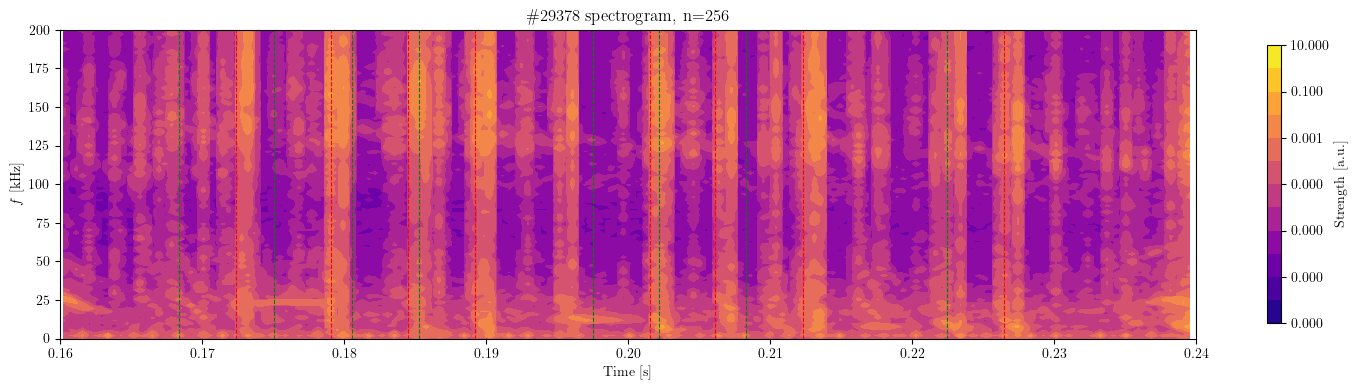

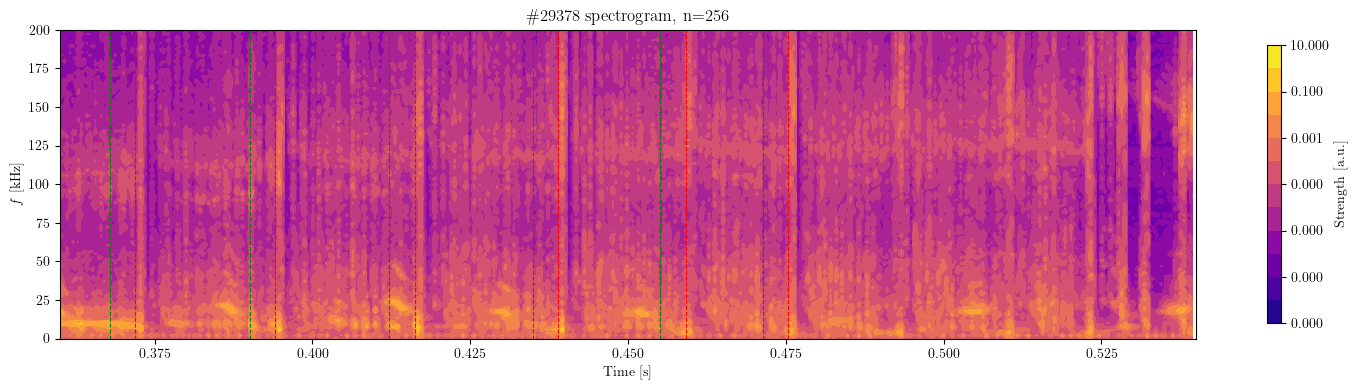

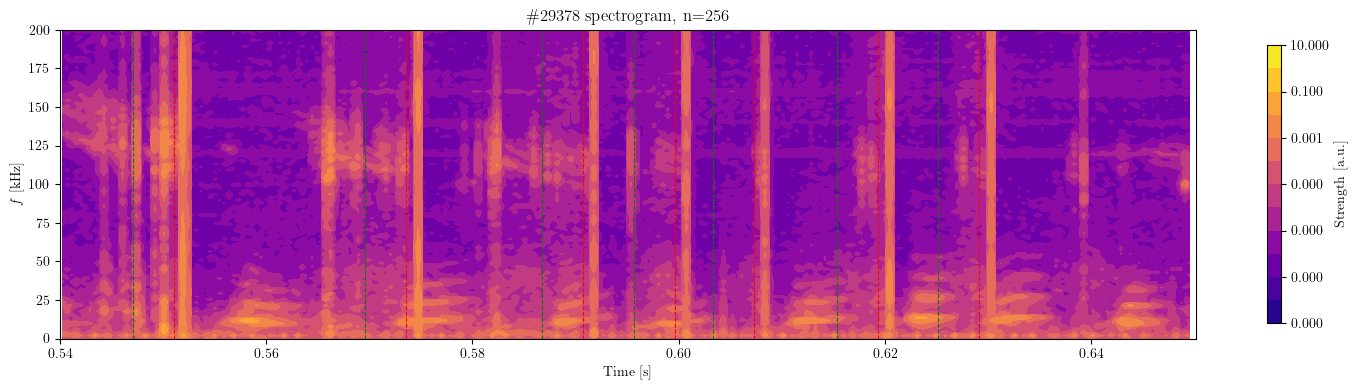

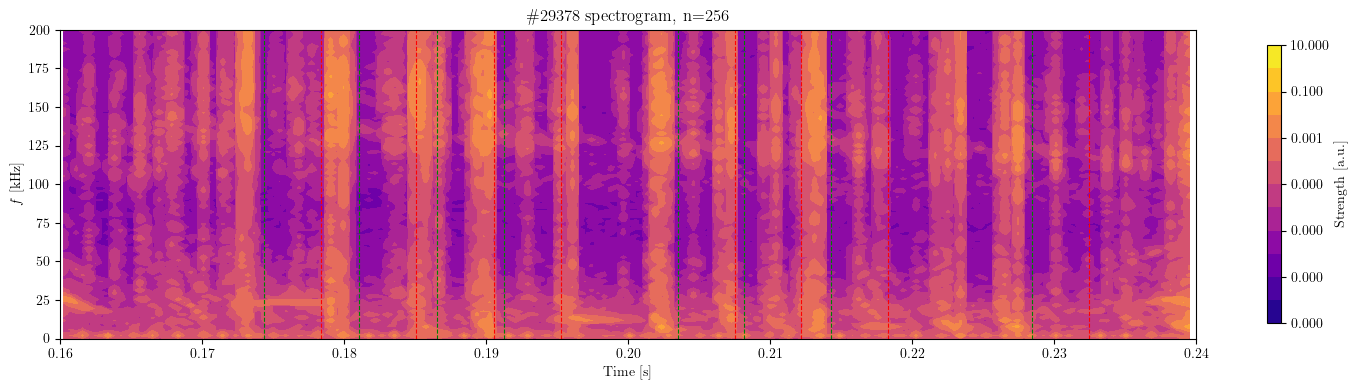

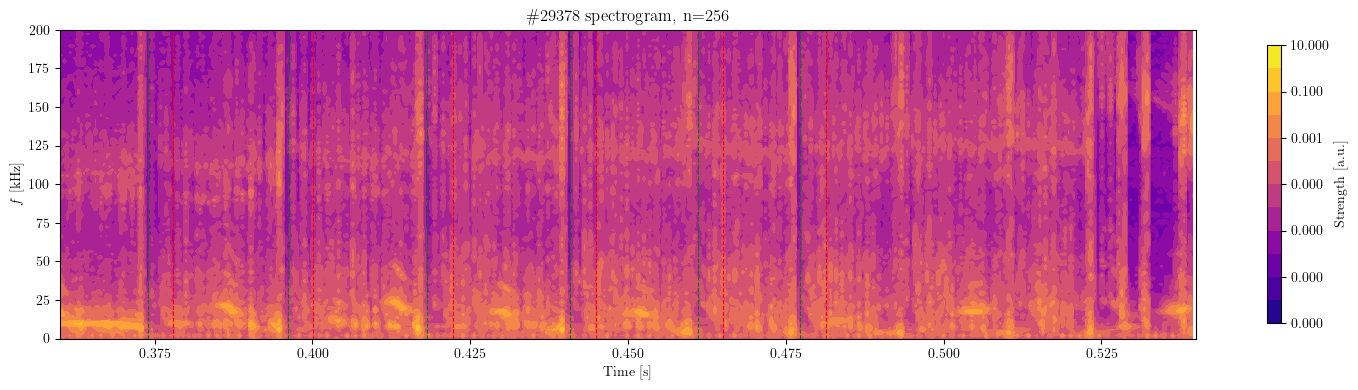

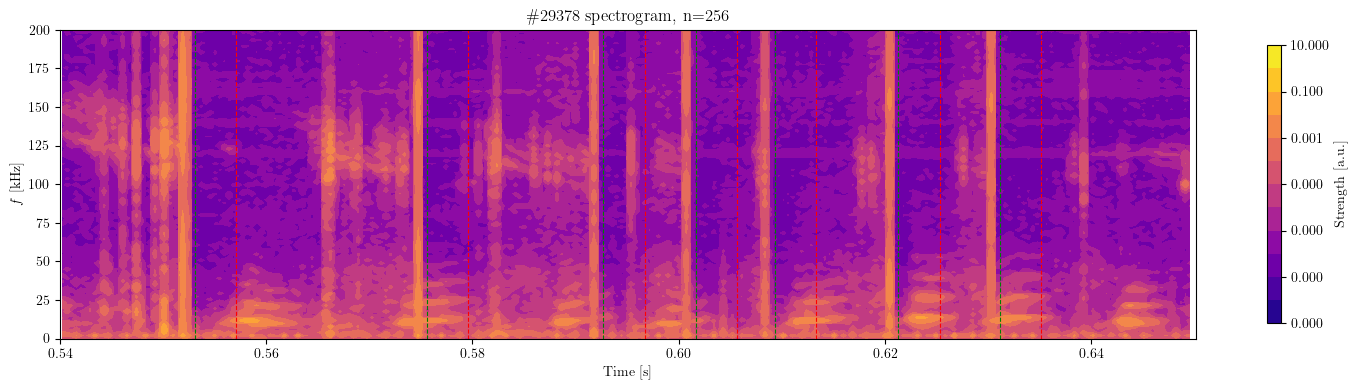

In [43]:
if True:
    # Show pre-crash windows first
    for i in range(len(regions)):
        sum_mirnov_fluct_spectrogram(shot, mirnov_time, mirnov_data, regions[i], n=8, vlines=pre_crash_windows[i], plot=True)

    # Then show post-crash windows
    for i in range(len(regions)):
        sum_mirnov_fluct_spectrogram(shot, mirnov_time, mirnov_data, regions[i], vlines=post_crash_windows[i], plot=True)

Manually worked out windows where the harmonics appear. Only includes those not significantly overlapping with crashes.

In [86]:
centres = [0.559, 0.6127, 0.624, 0.6335, 0.644] #[0.559, 0.575, 0.59, 0.6127, 0.624, 0.6335, 0.644]
manuals = [[i-0.0025, i+0.0025] for i in centres]
_ = sum_mirnov_fluct_spectrogram(shot, mirnov_time, mirnov_data, regions[2], n=8, vlines=manuals, plot=False)

For each window containing the harmonics produce a dispersion relation. Uses angular positions of coils relative to centre of magnetic axis.

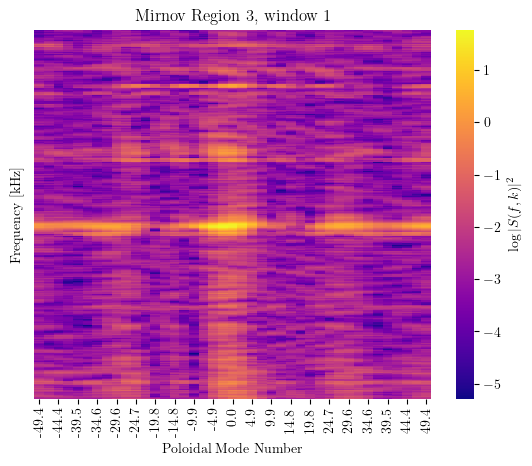

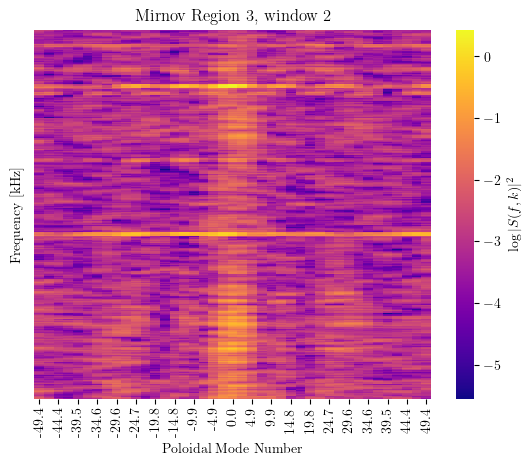

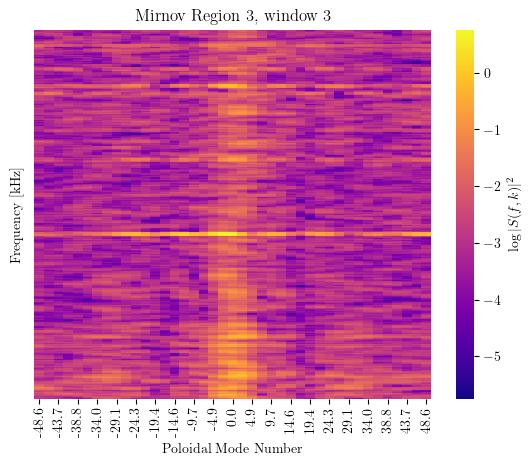

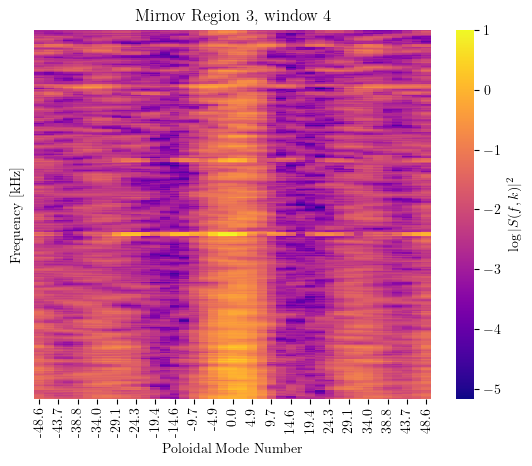

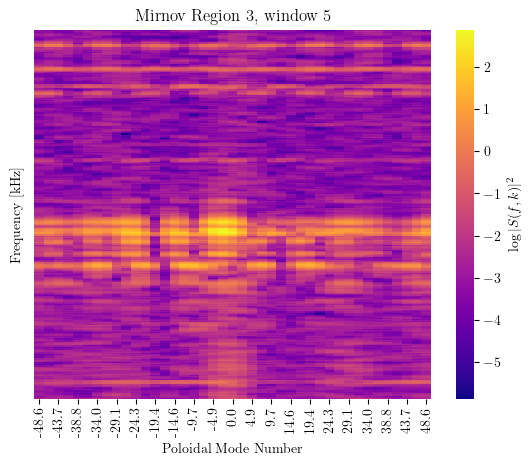

In [99]:
if False:
    for i in range(len(manuals)):
        centre_R, centre_Z = get_magnetic_centre(equilib_time, equilib_R, equilib_Z, equilib_psi, manuals[i])
        coilpos_angles = np.arctan((centre_Z-coilpos[:,1])/(centre_R-coilpos[:,0]))

        f_arr, k_arr, kf_matrix = get_kf_spec_mirnov(mirnov_time, mirnov_data, coilpos_angles, manuals[i])
        plot_kf_spec_mirnov(f_arr, k_arr, kf_matrix, "Mirnov Region 3, window " + str(i+1), fint=10.0e3, fmin=0.0, fmax=50.0e3, smooth_pts=5, conditional=False, save="window_"+str(i+1))

        """f_start = (np.abs(f_arr-0.0)).argmin()
        f_end = (np.abs(f_arr-60e3)).argmin()
        f_data = np.sum(kf_matrix[f_start:f_end,:], axis=1)

        fig, ax = plt.subplots(1, 1, figsize=(7, 3))

        l1 = ax.plot(f_arr[f_start:f_end]*1e-3, smooth(np.log(np.abs(f_data))**2,10), linewidth=0.5)
        ax.set_xlabel("Frequency [kHz]")
        ax.set_ylabel(r"$\log\vert S(f)\vert^2$")

        ax2 = ax.twinx()
        ax2.set_ylabel("Phase / rad.")
        l2 = ax2.plot(f_arr[f_start:f_end]*1e-3, np.angle(f_data), "m", linewidth=0.5)
        ax.legend(l1+l2, ["Power", "Phase"])
        ax.set_xlim(left=0, right=60)
        ax.set_title("Region 3, harmonics window " + str(i+1) + r" frequency profile")
        #plt.savefig("window_" + str(i+1) + "_f_profile.png", format="png", dpi=300)
        plt.show()"""

Plot Mirnov data filtered into different bands, for each region. Also plots $D_\alpha$ data over the top to compare with crash times.

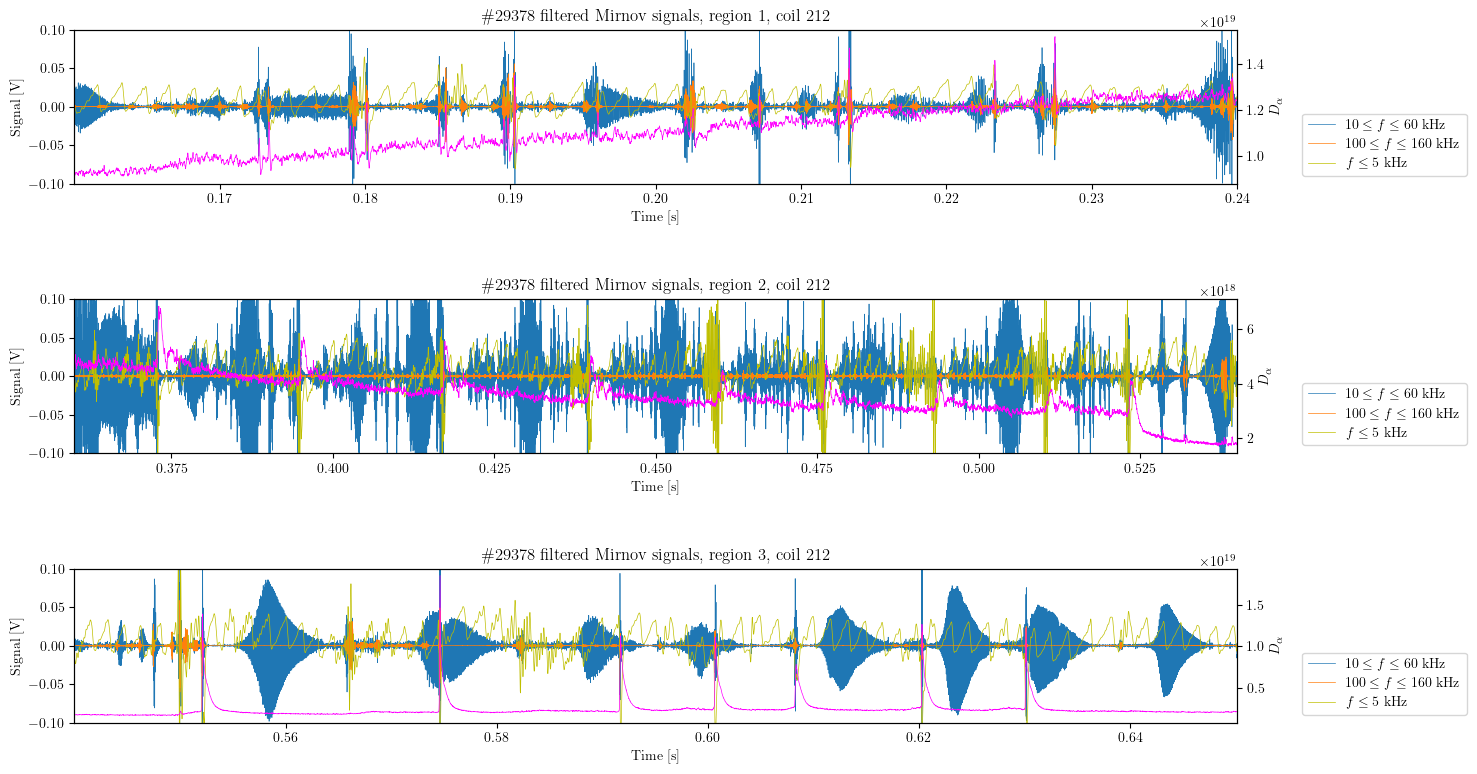

In [40]:
fig, ax = plt.subplots(3, 1, sharex=False, figsize=(15,3*len(regions)))
for i in range(len(regions)):
    idx1 = (np.abs(mirnov_time - regions[i][0])).argmin()
    idx2 = (np.abs(mirnov_time - regions[i][1])).argmin()
    dalpha_start= (np.abs(dalpha_time - regions[i][0])).argmin()
    dalpha_stop = (np.abs(dalpha_time - regions[i][1])).argmin()
    labels = []
    for coil in range(3,4):
        ax[i].plot(mirnov_time[idx1:idx2], smooth(butter_bandpass_filter(mirnov_data[coil][idx1:idx2], 10e3, 60e3, f_samp_mirnov),10), linewidth=0.5)
        ax[i].plot(mirnov_time[idx1:idx2], smooth(butter_bandpass_filter(mirnov_data[coil][idx1:idx2], 100e3, 160e3,  f_samp_mirnov),10), linewidth=0.5)
        ax[i].plot(mirnov_time[idx1:idx2], smooth(butter_lowpass_filter(mirnov_data[coil][idx1:idx2], 5e3, f_samp_mirnov),10), "y", linewidth=0.5)

    ax2 = ax[i].twinx()
    ax2.plot(dalpha_time[dalpha_start:dalpha_stop], dalpha_data[dalpha_start:dalpha_stop], "magenta", linewidth=0.5)
    ax2.set_ylabel(r"$D_\alpha$")

    #ax[i].set_xlim(left=crash_times[i][0]-0.001,right=crash_times[i][-1]+0.001)
    ax[i].set_xlim(left=mirnov_time[idx1], right=mirnov_time[idx2])
    ax[i].set_ylim(bottom=-0.1,top=0.1)
    ax[i].legend([r"$10\leq f\leq60$ kHz", r"$100\leq f\leq160$ kHz", r"$f\leq5$ kHz"], bbox_to_anchor=(1.05, 0.5))
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("Signal [V]")
    ax[i].set_title("\#" + str(shot) + " filtered Mirnov signals, region " + str(i+1) + ", coil 212")

fig.subplots_adjust(hspace=0.75)
#plt.savefig("mirnov_filt_combi.pdf", bbox_inches="tight", format="pdf")
plt.show()

As above, but plot each band on separate axes so some things can be seen better.

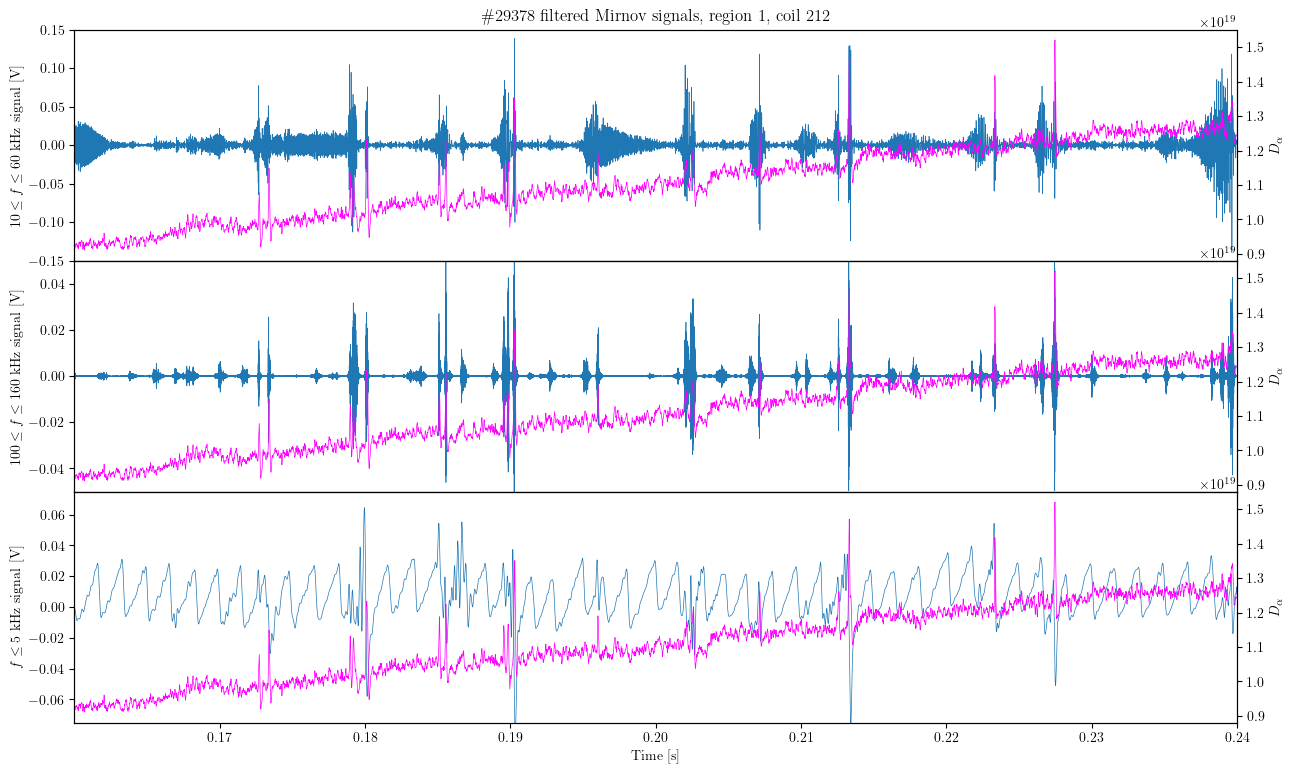

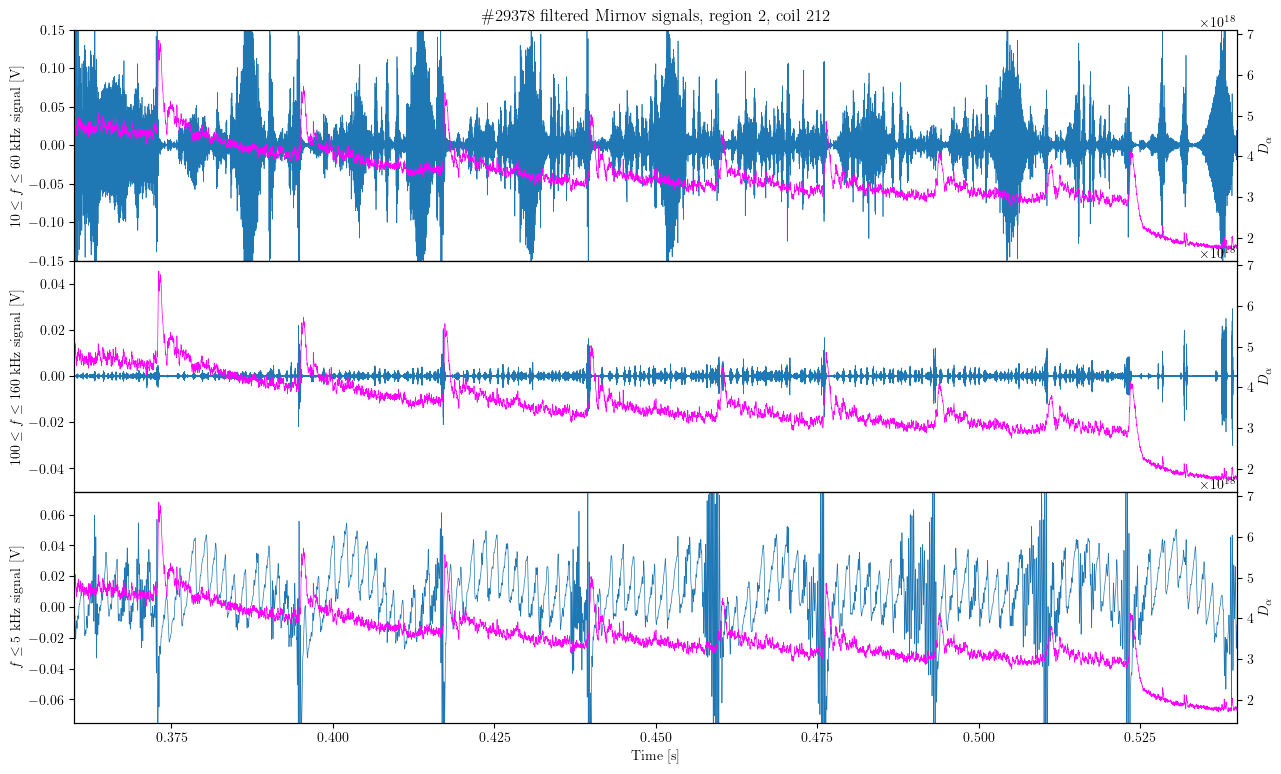

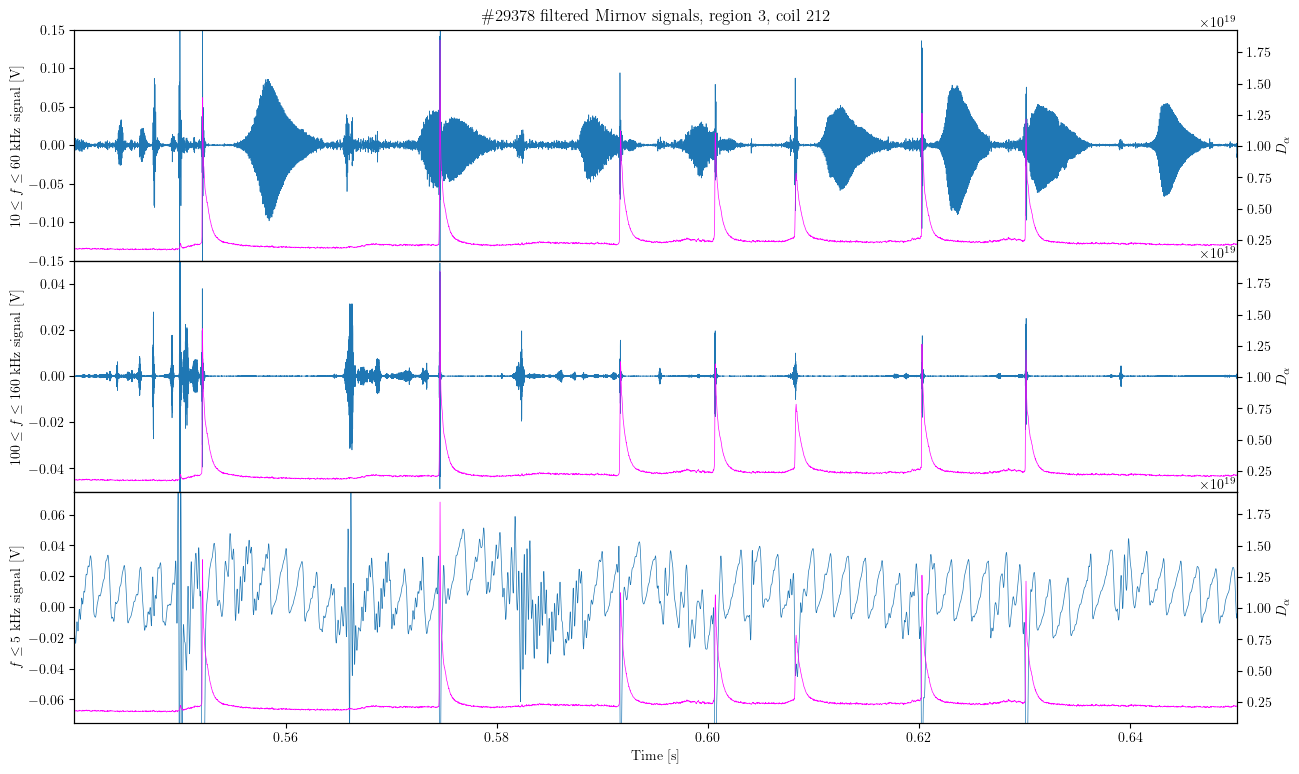

In [39]:
for i in range(len(regions)):
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(15,9))
    idx1 = (np.abs(mirnov_time - regions[i][0])).argmin()
    idx2 = (np.abs(mirnov_time - regions[i][1])).argmin()
    dalpha_start= (np.abs(dalpha_time - regions[i][0])).argmin()
    dalpha_stop = (np.abs(dalpha_time - regions[i][1])).argmin()
    
    ax[0].plot(mirnov_time[idx1:idx2], smooth(butter_bandpass_filter(mirnov_data[3][idx1:idx2], 10e3, 60e3, f_samp_mirnov),10), linewidth=0.5)
    ax[0].set_ylabel(r"$10\leq f\leq60$ kHz signal [V]")
    ax[0].set_ylim(bottom=-0.15, top=0.15)
    
    ax[1].plot(mirnov_time[idx1:idx2], smooth(butter_bandpass_filter(mirnov_data[3][idx1:idx2], 100e3, 160e3,  f_samp_mirnov),10), linewidth=0.5)
    ax[1].set_ylabel(r"$100\leq f\leq160$ kHz signal [V]")
    ax[1].set_ylim(bottom=-0.05, top=0.05)
    
    ax[2].plot(mirnov_time[idx1:idx2], smooth(butter_lowpass_filter(mirnov_data[3][idx1:idx2], 5e3, f_samp_mirnov),10), linewidth=0.5)
    ax[2].set_ylabel(r"$f\leq5$ kHz signal [V]")
    ax[2].set_ylim(bottom=-0.075, top=0.075)    

    for x in range(3):
        ax2 = ax[x].twinx()
        ax2.plot(dalpha_time[dalpha_start:dalpha_stop], dalpha_data[dalpha_start:dalpha_stop], "magenta", linewidth=0.5)
        ax2.set_ylabel(r"$D_\alpha$")
    ax[-1].set_xlim(left=mirnov_time[idx1], right=mirnov_time[idx2])
    ax[-1].set_xlabel("Time [s]")
    ax[0].set_title("\#" + str(shot) + " filtered Mirnov signals, region " + str(i+1) + ", coil 212")
    fig.subplots_adjust(hspace=0)
    #plt.savefig("reg_" + str(i+1) + "_mirnov_filt_seperated.pdf", format="pdf", bbox_inches="tight")
    plt.show()

As above, but this time using BES data. $f\leq5$ kHz band is uninteresting and includes turbulence so don't look at it.

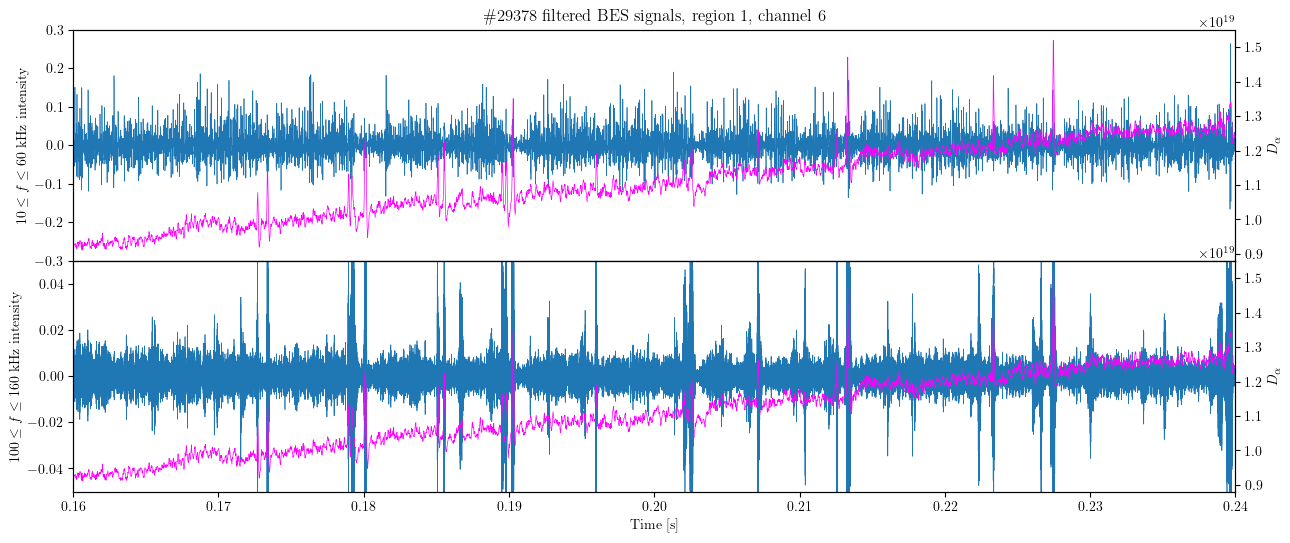

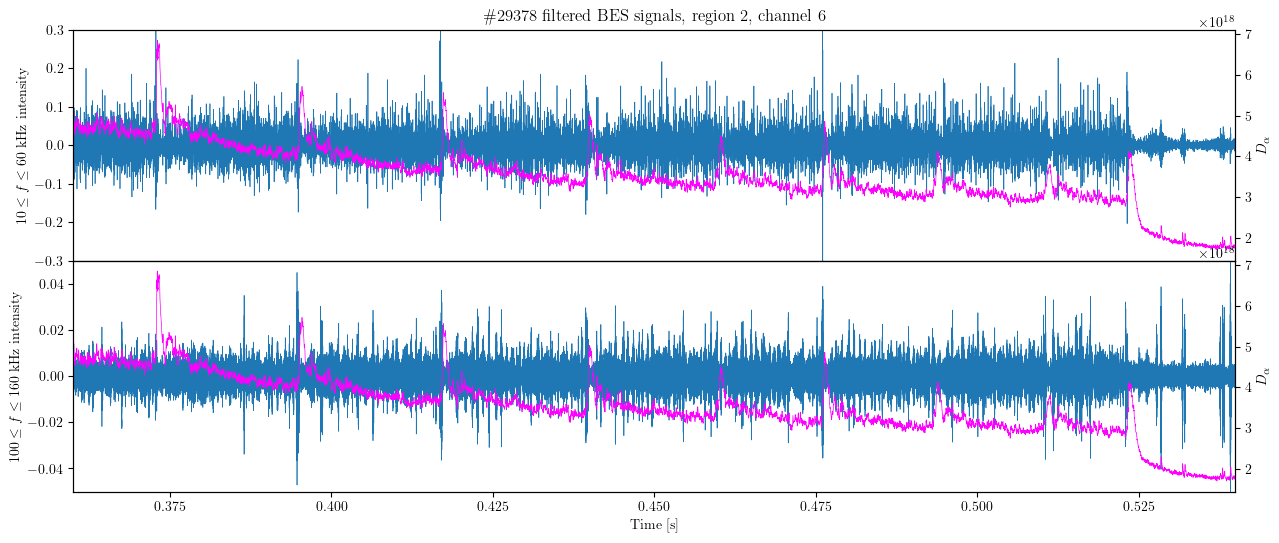

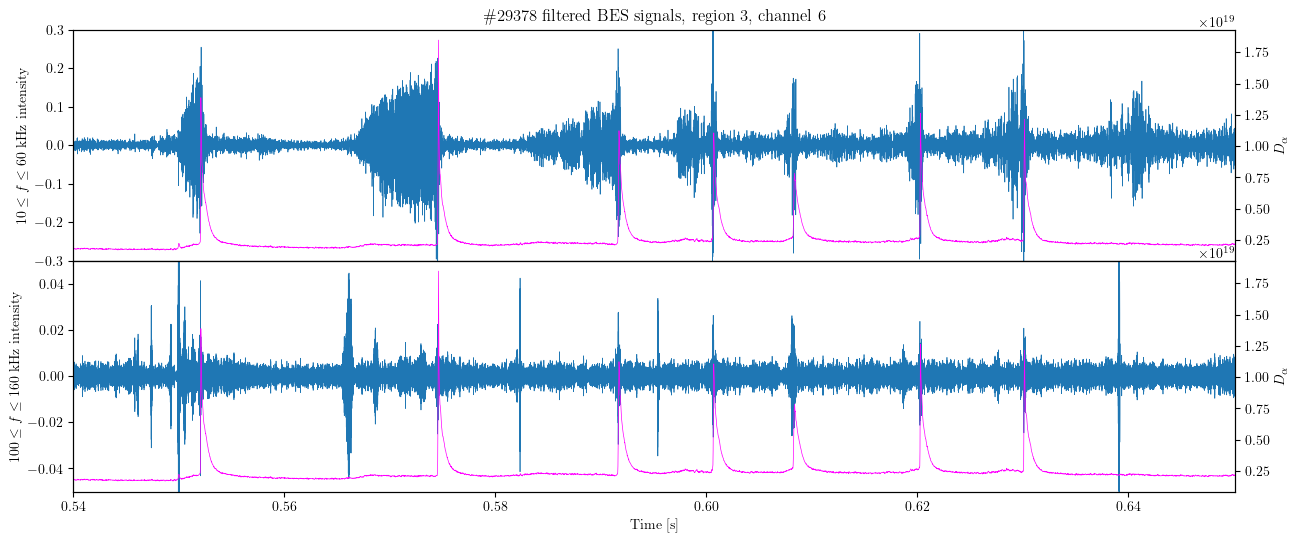

In [20]:
for i in range(len(regions)):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,6))
    idx1 = (np.abs(bes_time - regions[i][0])).argmin()
    idx2 = (np.abs(bes_time - regions[i][1])).argmin()
    dalpha_start= (np.abs(dalpha_time - regions[i][0])).argmin()
    dalpha_stop = (np.abs(dalpha_time - regions[i][1])).argmin()
    
    ax[0].plot(bes_time[idx1:idx2], smooth(butter_bandpass_filter(fluct_data[5][idx1:idx2], 10e3, 60e3, f_samp),10), linewidth=0.5)
    ax[0].set_ylabel(r"$10\leq f\leq60$ kHz intensity")
    ax[0].set_ylim(bottom=-0.3, top=0.3)
    
    ax[1].plot(bes_time[idx1:idx2], smooth(butter_bandpass_filter(fluct_data[5][idx1:idx2], 100e3, 160e3,  f_samp),10), linewidth=0.5)
    ax[1].set_ylabel(r"$100\leq f\leq160$ kHz intensity")
    ax[1].set_ylim(bottom=-0.05, top=0.05)

    for x in range(2):
        ax2 = ax[x].twinx()
        ax2.plot(dalpha_time[dalpha_start:dalpha_stop], dalpha_data[dalpha_start:dalpha_stop], "magenta", linewidth=0.5)
        ax2.set_ylabel(r"$D_\alpha$")
    ax[-1].set_xlim(left=bes_time[idx1], right=bes_time[idx2])
    ax[-1].set_xlabel("Time [s]")
    ax[0].set_title("\#" + str(shot) + " filtered BES signals, region " + str(i+1) + ", channel 6")
    fig.subplots_adjust(hspace=0)
    plt.savefig("reg_" + str(i+1) + "_BES_filt_seperated.pdf", format="pdf", bbox_inches="tight")
    #plt.show()

Function to find the cross correlation between two arrays (of equal size). Returns lags in seconds and coefficients.

In [15]:
def cross_corr(refch, ch, dt):
    cross_corr_coeff = np.fft.ifft(np.fft.fft(refch) * np.conj(
            np.fft.fft(ch))) / (len(ch) * np.sqrt(
                    np.mean(refch ** 2) * np.mean(ch ** 2)))
    lags = dt*np.linspace(-0.5*len(cross_corr_coeff), 0.5*len(cross_corr_coeff), len(cross_corr_coeff))
    return lags, np.roll(cross_corr_coeff, int(0.5 * len(cross_corr_coeff)))

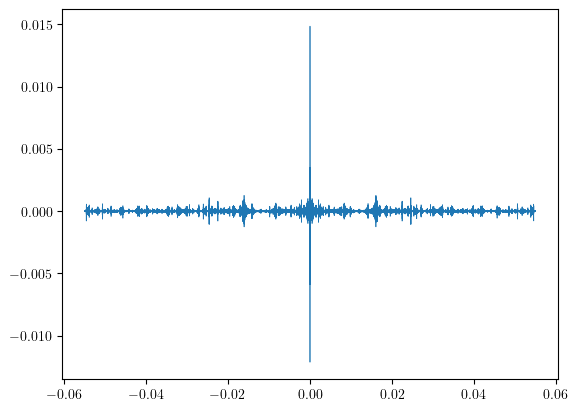

In [17]:
idx1 = (np.abs(mirnov_time-regions[2][0])).argmin()
idx2 = (np.abs(mirnov_time-regions[2][1])).argmin()
sig1 = butter_bandpass_filter(mirnov_data[3][idx1:idx2], 100e3, 160e3, f_samp_mirnov)
sig2 = butter_bandpass_filter(mirnov_data[3][idx1:idx2], 10e3, 60e3, f_samp_mirnov)
sig3 = butter_lowpass_filter(mirnov_data[3][idx1:idx2], 5e3, f_samp_mirnov)

cross_correlation = cross_corr(sig1, sig2, 1/f_samp_mirnov)
plt.plot(cross_correlation[0], cross_correlation[1], linewidth=0.5)
plt.show()

Function that plots like a dispersion relation but instead of power shows phase.

In [98]:
def plot_kf_phases(f_arr, k_arr, kf_matrix, plot_title, fint=50.0, fmin=0.0, fmax=None, smooth_pts=None, conditional=False, save=False):
    if fmax == None:
        fmax = np.max(f_arr)
        
    if smooth_pts != None:
        line_idx = np.abs(f_arr - fmin).argmin()
        this_block = np.sum(np.abs(kf_matrix[line_idx:line_idx+smooth_pts]), axis=0)
        smooth_spec = np.array(this_block)
        smooth_freqs = np.array(f_arr[line_idx])
        line_idx += 1
        
        while line_idx < np.abs(f_arr - fmax).argmin() + smooth_pts:
            this_block = np.sum(np.abs(kf_matrix[line_idx:line_idx+smooth_pts]), axis=0)
            smooth_spec = np.vstack((smooth_spec, this_block))
            smooth_freqs = np.append(smooth_freqs, f_arr[line_idx])
            line_idx += 1
        kf_matrix = smooth_spec
        f_arr = smooth_freqs
        
    if conditional == True:
        kf_matrix = np.transpose(np.transpose(kf_matrix)/np.sum(kf_matrix,axis=1))
        cbar_label = "Phase (conditional)"
    else:
        cbar_label = "Phase"
    
    # Only need to plot a section of the spectrum. At least half not needed.
    kf_matrix = kf_matrix[(np.abs(f_arr - fmin)).argmin():(np.abs(f_arr - fmax)).argmin()]
    f_arr = f_arr[(np.abs(f_arr - fmin)).argmin():(np.abs(f_arr - fmax)).argmin()]
    
    # Shift phase relative to a particular point, then shift to right range.
    kf_matrix = np.angle(kf_matrix)
    refphase = kf_matrix[19,20]
    print(f_arr[20], refphase)
    kf_matrix -= refphase
    for f in range(len(f_arr)):
        for m in range(len(k_arr)):
            if kf_matrix[f,m] < -np.pi:
                kf_matrix[f,m] += 2*np.pi
            elif kf_matrix[f,m] > np.pi:
                kf_matrix[f,m] -= 2*np.pi

    # Convert to array with rounded frequencies for easier of plotting.
    kf_matrix_plot = pd.DataFrame(kf_matrix, index=np.around(f_arr*1e-3,0), columns=np.around(k_arr,1))

    # For only plotting tick at every x kHz
    interval = int(np.abs(f_arr - fint).argmin())

    # Plot log of values so small enough range for features to be visible
    sns.heatmap(kf_matrix_plot[::-1], yticklabels=interval, cmap="plasma", cbar_kws={"label": cbar_label})
    plt.title(plot_title)
    plt.ylabel("Frequency [kHz]")
    plt.xlabel("Poloidal Mode Number")
    if save != False:
        plt.savefig(save + ".png", format="png", bbox_inches="tight", dpi=300)
    else:
        plt.show()
    plt.close()

Make some phase relation plots for each window in region 3 containing the harmonics.

3999.977272860616 -0.7851864807424908


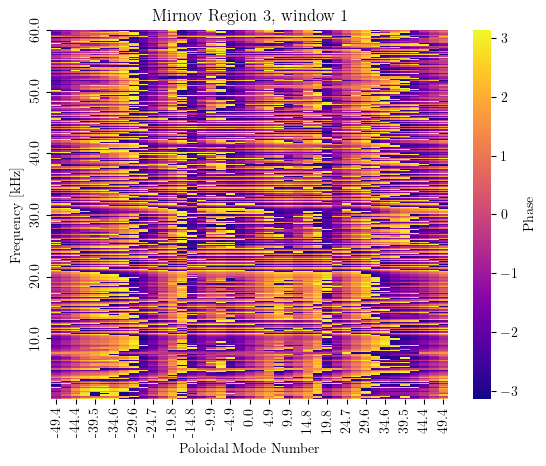

4000.025021359844 -1.0539787424978893


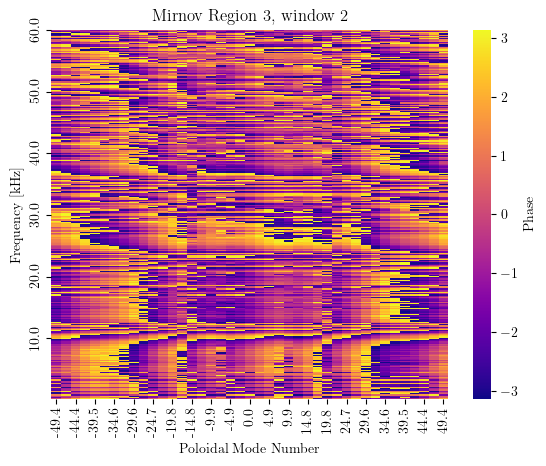

3999.977272860616 -1.6639513380882698


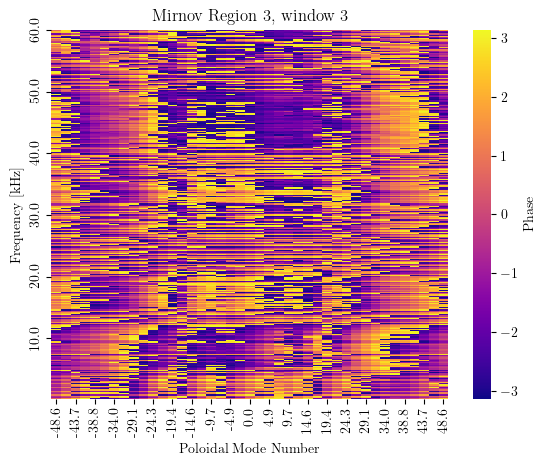

4000.025021359844 -0.12319519486919243


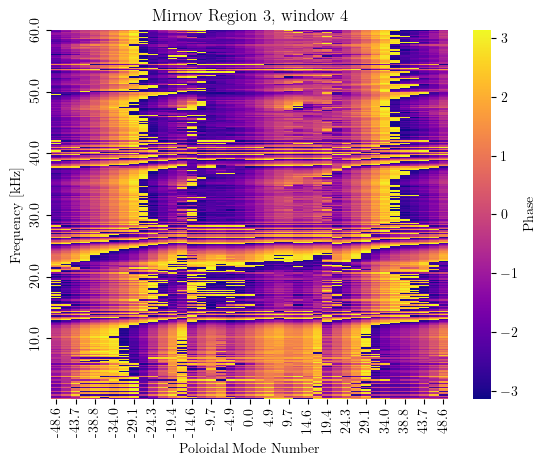

3999.977272860616 1.531458415008699


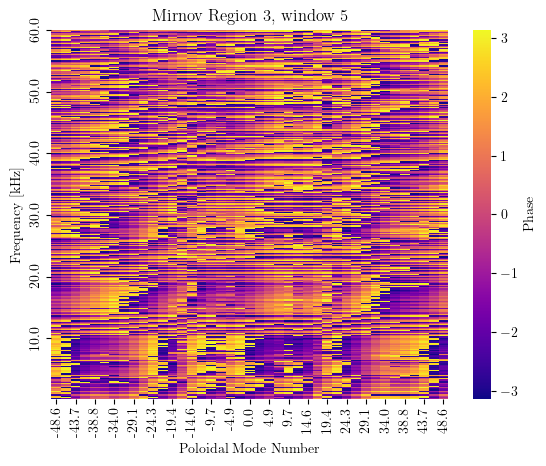

In [101]:
for i in range(len(manuals)):
    centre_R, centre_Z = get_magnetic_centre(equilib_time, equilib_R, equilib_Z, equilib_psi, manuals[i])
    coilpos_angles = np.arctan((centre_Z-coilpos[:,1])/(centre_R-coilpos[:,0]))
    
    f_arr, k_arr, kf_matrix = get_kf_spec_mirnov(mirnov_time, mirnov_data, coilpos_angles, manuals[i])
    plot_kf_phases(f_arr, k_arr, kf_matrix, "Mirnov Region 3, window " + str(i+1), fint=10.0e3, fmin=0.0e3, fmax=60.0e3, smooth_pts=None, conditional=False, save=False)

## Integrating magnetics with BES

Look at features that show up in the time FFT of a channel and compare scale of features seen in each coil and relation to their distance apart

Function to work out how far apart a BES channel focal point is from a Mirnov coil

In [13]:
def bes_mirnov_dist(apdpos, bes_ch, coilpos, mirnov_idx):
    path = coilpos[mirnov_idx] - apdpos[bes_ch]
    return np.sqrt(path[0]**2 + path[1]**2), path

Plot both BES focal points and Mirnov coil positions, with some demo paths between them

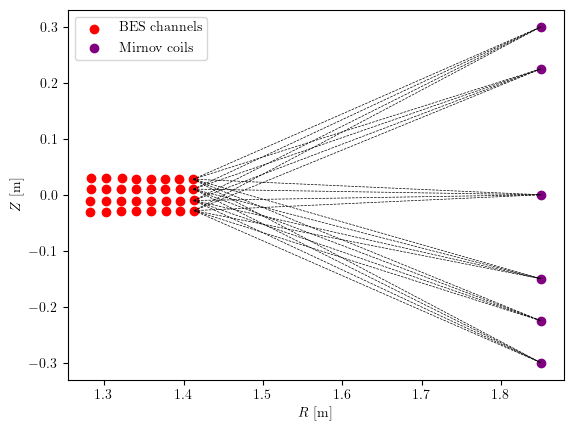

In [14]:
if True:
    fig, ax = plt.subplots(1,1)
    ax.scatter(apdpos[:,0], apdpos[:,1], marker="o", color="red", label="BES channels")
    ax.scatter(coilpos[:,0], coilpos[:,1], marker="o", color="purple", label="Mirnov coils")
    for ch in range(7,32,8):
        for coil in range(6):
            dist, path = bes_mirnov_dist(apdpos, ch, coilpos, coil)
            plt.plot([apdpos[ch,0], apdpos[ch,0]+path[0]], [apdpos[ch,1], apdpos[ch,1]+path[1]], "k--", linewidth=0.5)

    ax.set_xlabel(r"$R$ [m]")
    ax.set_ylabel(r"$Z$ [m]")
    ax.legend()
    plt.show()

In [17]:
fluct_filt = butter_highpass_filter(fluct_data, 5e3, f_samp)
mirnov_filt = butter_highpass_filter(mirnov_data, 5e3, f_samp_mirnov)

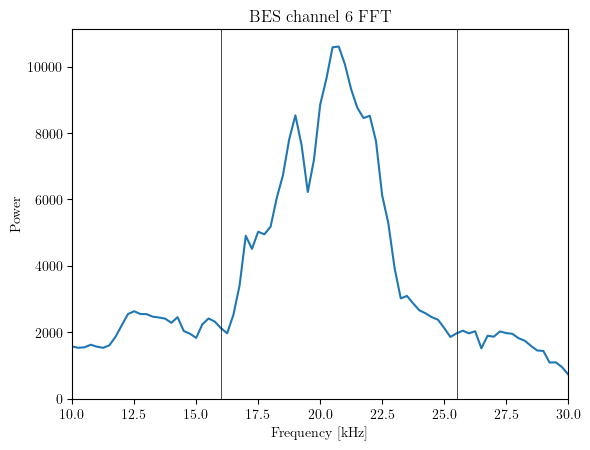

In [38]:
freqs, coeffs = fft_channel(bes_time, fluct_filt, 5, pre_crash_windows[2][0])
coeffs_sum = np.abs(coeffs)
for window in range(1,len(pre_crash_windows[2])):
    coeffs_sum += np.abs(fft_channel(bes_time, fluct_filt, 5, pre_crash_windows[2][i])[1])
fig, ax = plt.subplots()
ax.plot(freqs*1e-3, smooth((np.abs(coeffs_sum)**2),10))
ax.set_xlim(left=10, right=30)
ax.set_xlabel("Frequency [kHz]")
ax.set_ylim(bottom=0)
ax.set_ylabel("Power")
ax.set_title("BES channel 6 FFT")

limits = [16,25.5]
ax.vlines(limits[0], ax.get_ylim()[0], ax.get_ylim()[1], "k", linewidth=0.5)
ax.vlines(limits[1], ax.get_ylim()[0], ax.get_ylim()[1], "k", linewidth=0.5)

plt.show()

In [22]:
areas = []
for ch in range(32):
    freqs, coeffs = fft_channel(bes_time, fluct_filt, ch, pre_crash_windows[2][0])
    coeffs_sum = np.abs(coeffs)
    for window in range(1,len(pre_crash_windows[2])):
        coeffs_sum += np.abs(fft_channel(bes_time, fluct_filt, ch, pre_crash_windows[2][i])[1])
    
    if False:
        fig, ax = plt.subplots()
        ax.plot(freqs*1e-3, smooth((np.abs(coeffs_sum)**2),10))
        ax.set_xlim(left=10, right=30)
        ax.set_xlabel("Frequency [kHz]")
        ax.set_ylim(bottom=0)
        ax.set_ylabel("Power")

        limits = [16,25.5]
        ax.vlines(limits[0], ax.get_ylim()[0], ax.get_ylim()[1], "k", linewidth=0.5)
        ax.vlines(limits[1], ax.get_ylim()[0], ax.get_ylim()[1], "k", linewidth=0.5)
        plt.show()
        plt.close()
    
    idx1 = (np.abs(freqs*1e-3 - limits[0])).argmin()
    idx2 = (np.abs(freqs*1e-3 - limits[1])).argmin()
    full = trapz(coeffs_sum[idx1:idx2+1], freqs[idx1:idx2+1])
    noise = trapz([coeffs_sum[idx1], coeffs_sum[idx2]], [freqs[idx1], freqs[idx2]])
    areas.append(full-noise)

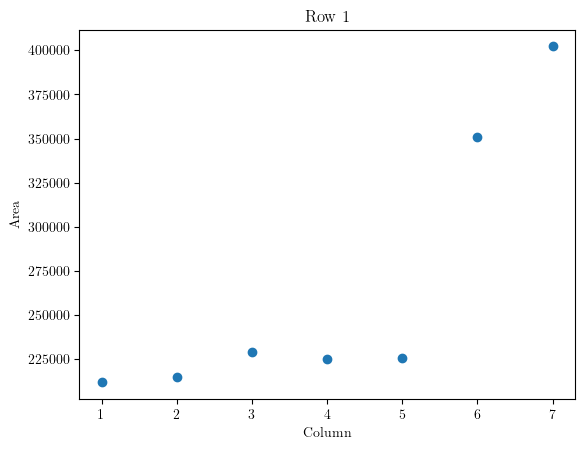

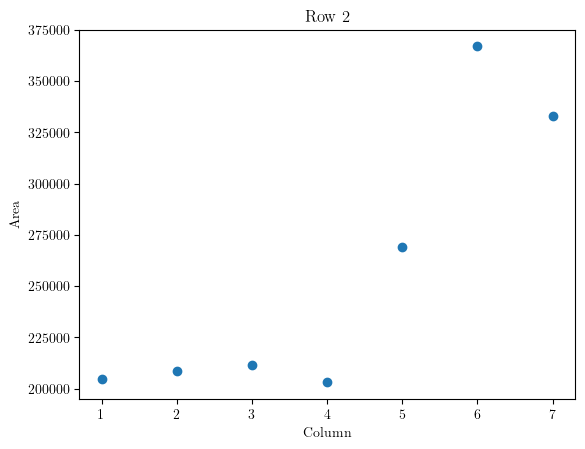

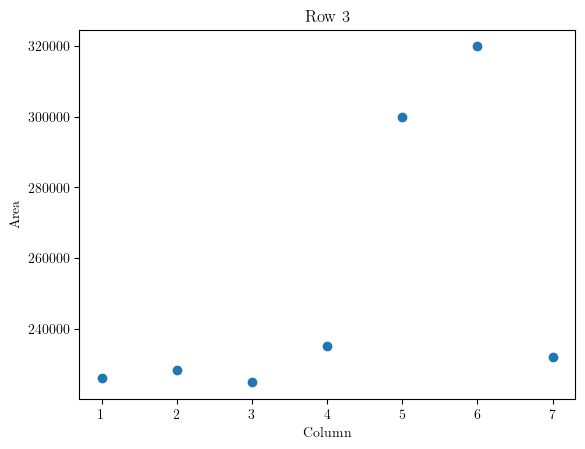

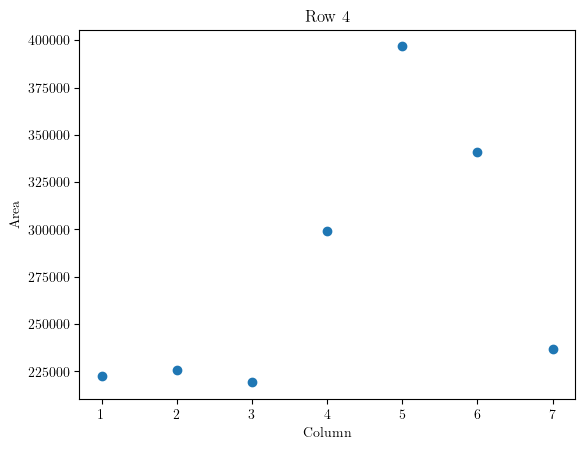

In [150]:
for row in range(4):
    plt.scatter(np.arange(1,8), [areas[i] for i in range(8*row,8*row+7)])
    plt.xlabel("Column")
    plt.ylabel("Area")
    plt.title("Row " + str(row+1))
    plt.show()

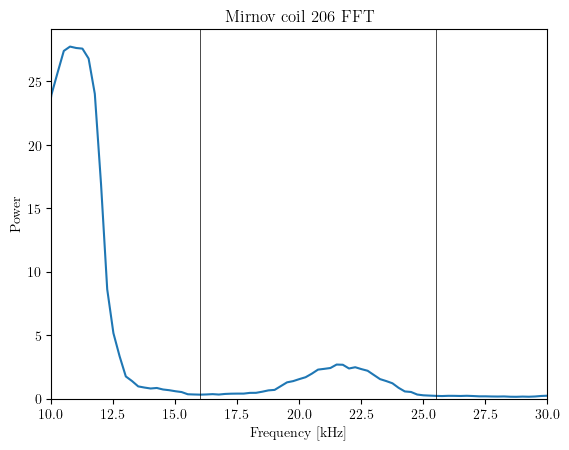

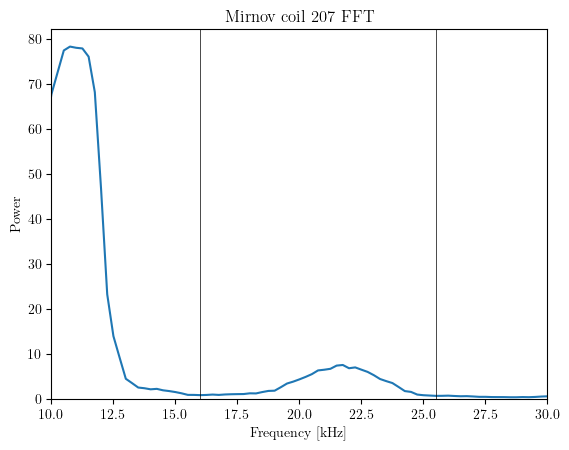

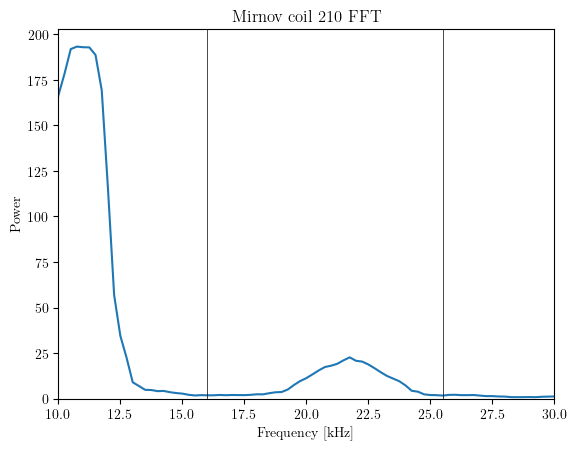

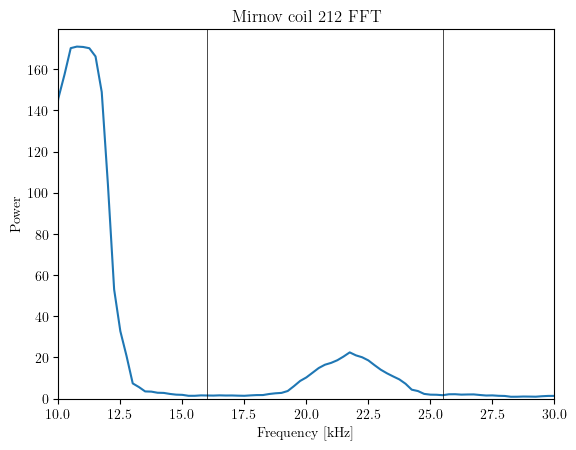

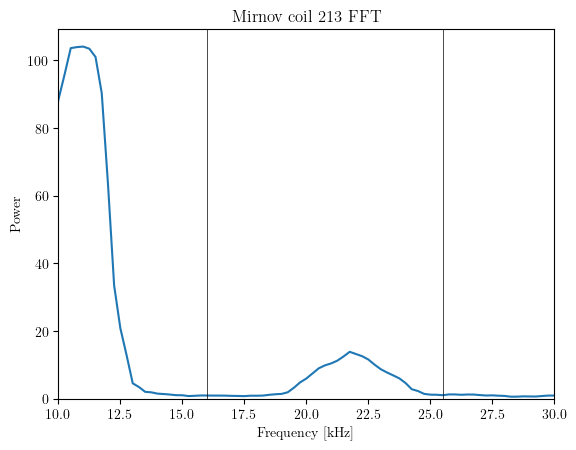

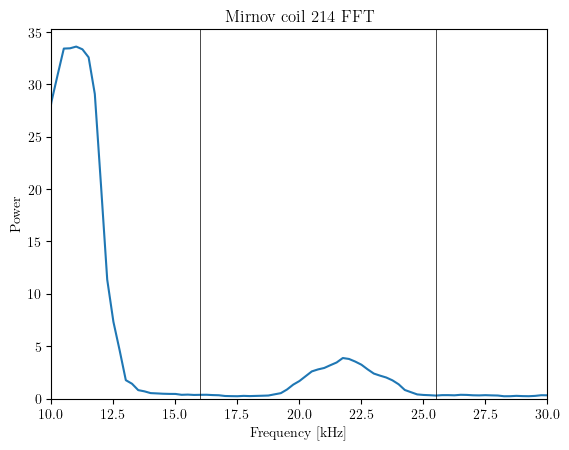

In [40]:
mareas = []
for coil in range(6):
    freqs, coeffs = fft_channel(mirnov_time, mirnov_filt, coil, pre_crash_windows[2][0])
    coeffs_sum = np.abs(coeffs)
    for window in range(1,len(pre_crash_windows[2])):
        coeffs_sum += np.abs(fft_channel(mirnov_time, mirnov_filt, coil, pre_crash_windows[2][i])[1])

    fig, ax = plt.subplots()
    ax.plot(freqs*1e-3, smooth((np.abs(coeffs_sum)**2),10))
    ax.set_xlim(left=10, right=30)
    ax.set_xlabel("Frequency [kHz]")
    ax.set_ylim(bottom=0)
    ax.set_ylabel("Power")
    ax.set_title("Mirnov coil " + str(coil_nums[coil]) + " FFT")

    limits = [16,25.5]
    ax.vlines(limits[0], ax.get_ylim()[0], ax.get_ylim()[1], "k", linewidth=0.5)
    ax.vlines(limits[1], ax.get_ylim()[0], ax.get_ylim()[1], "k", linewidth=0.5)
    plt.show()
        
    idx1 = (np.abs(freqs*1e-3 - limits[0])).argmin()
    idx2 = (np.abs(freqs*1e-3 - limits[1])).argmin()
    full = trapz(coeffs_sum[idx1:idx2+1], freqs[idx1:idx2+1])
    noise = trapz([coeffs_sum[idx1], coeffs_sum[idx2]], [freqs[idx1], freqs[idx2]])
    mareas.append(full-noise)

Function to determine frequency peaks from Mirnov dispersion relations.

Sum abs across wavenumbers, produce smoother frequency profile.

In [19]:
def get_mirnov_ksum(equilib_time, equilib_R, equilib_Z, equilib_psi,
                    mirnov_time, mirnov_data, f_start, f_end, timeslice):
    centre_R, centre_Z = get_magnetic_centre(equilib_time, equilib_R, equilib_Z, equilib_psi, timeslice)
    coilpos_angles = np.arctan((centre_Z-coilpos[:,1])/(centre_R-coilpos[:,0]))

    f_arr, k_arr, kf_matrix = get_kf_spec_mirnov(mirnov_time, mirnov_data, coilpos_angles, timeslice)
    f_start_idx = (np.abs(f_arr - f_start)).argmin()
    f_end_idx = (np.abs(f_arr - f_end)).argmin()
    
    sum_over_k = np.sum(np.abs(kf_matrix)**2,axis=1)
    smoothed = np.log(smooth(sum_over_k,10))[f_start_idx:f_end_idx]
    f_arr = f_arr[f_start_idx:f_end_idx]
    
    fig, ax = plt.subplots(1,1)
    ax.plot(f_arr*1e-3, smoothed, linewidth=0.5)
    ax.set_xlim(left=f_start*1e-3, right=f_end*1e-3)
    ax.set_xlabel("Frequency [kHz]")
    ax.set_ylabel("Power [a.u.]")
    plt.show()
    plt.close()
    return sum_over_k

In [102]:
if False:
    for window in manuals:
        get_mirnov_ksum(equilib_time, equilib_R, equilib_Z, equilib_psi, mirnov_time, mirnov_data, 5e3, 15e3, window)

For each window in manuals, where do we see frequency peaking?

In [23]:
harmonic_freqs = np.asarray([
    [[8.0,14.0], [18.0, 26.0], [29.0, 38.0]],
    [[8.0,14.0], [20.0, 27.0], [31.0, 40.0]],
    [[10.0,16.0], [22.0, 29.0], [36.0, 42.0]],
    [[8.0,15.0], [22.0, 30.0], [34.0, 43.0]],
    [[7.0,14.0], [19.0, 26.0], [29.0, 36.0]]
])*1e3

For each harmonic for each of manuals, re-compute dispersion relation, sum contributions in the range and plot poloidal mode number profile.

1 & 1 & 0.263 & 0.669 & 2.794 \\


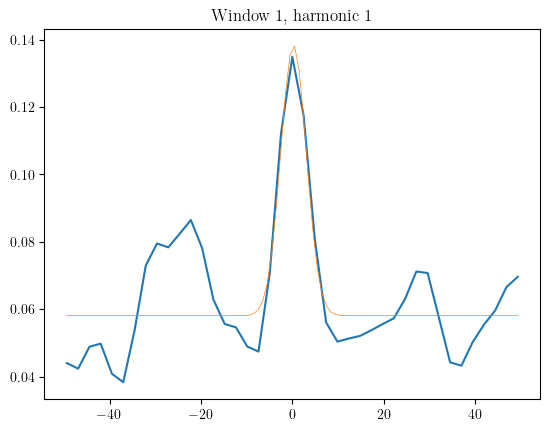

1 & 2 & -0.954 & 0.81 & 3.705 \\


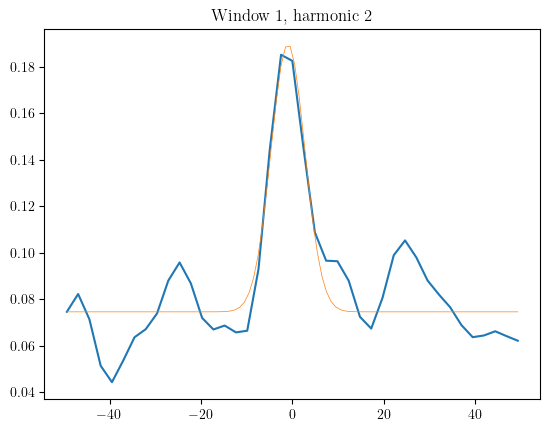

1 & 3 & 0.244 & 0.773 & 2.996 \\


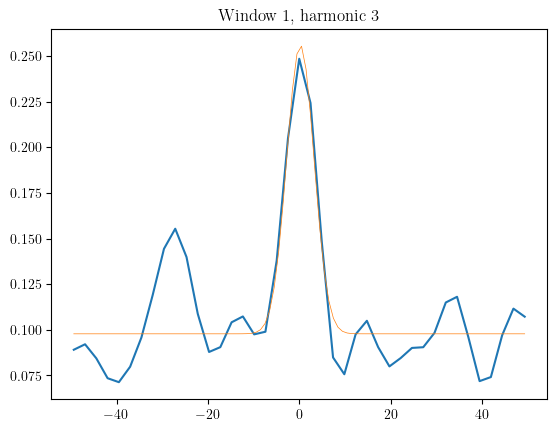

2 & 1 & 0.988 & 0.695 & 3.235 \\


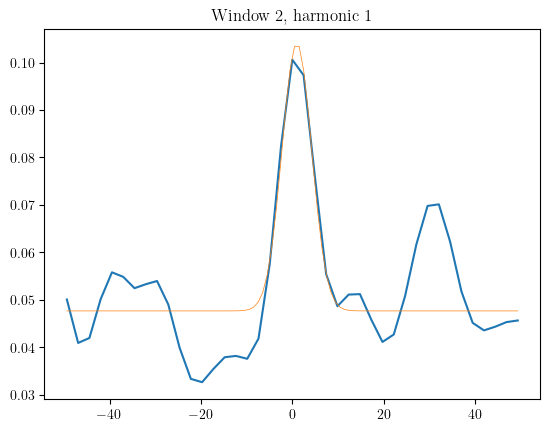

2 & 2 & -0.171 & 0.861 & 2.768 \\


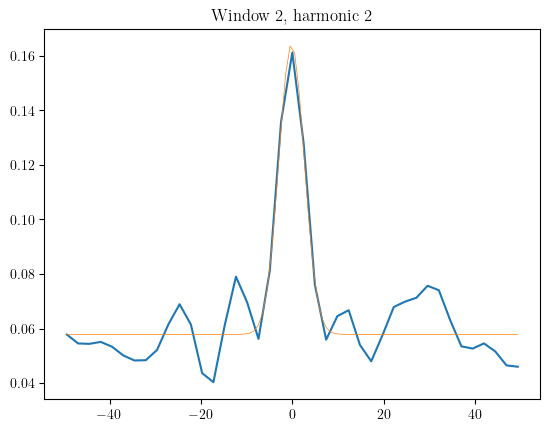

2 & 3 & -0.269 & 0.716 & 3.203 \\


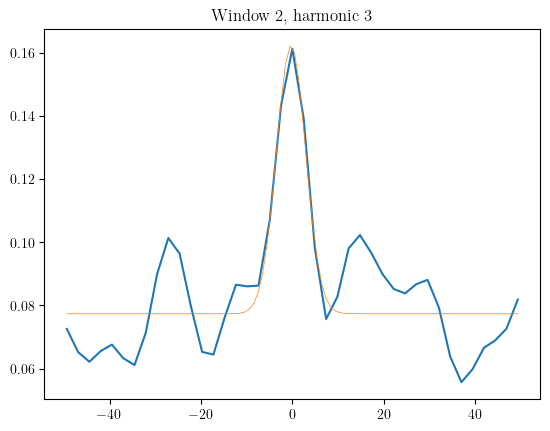

3 & 1 & 0.838 & 0.853 & 3.483 \\


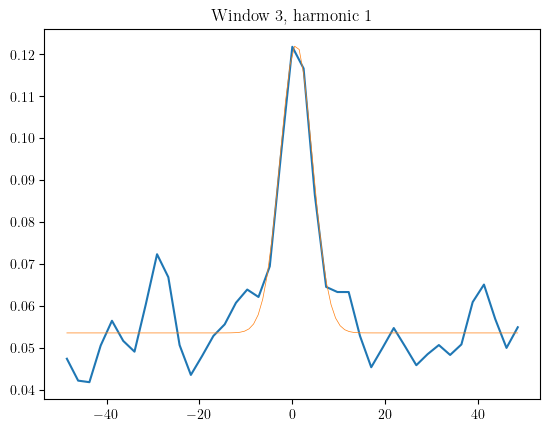

3 & 2 & 1.026 & 0.779 & 5.295 \\


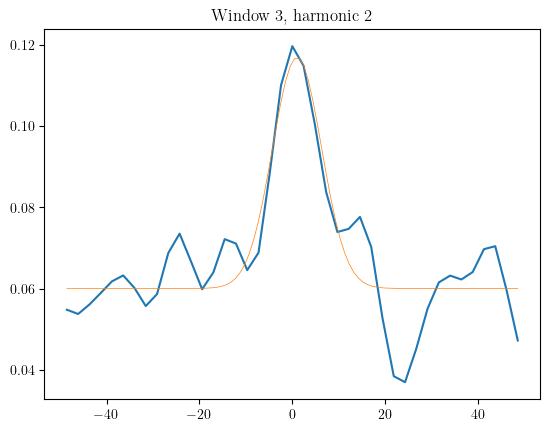

3 & 3 & -1.243 & 0.682 & 3.795 \\


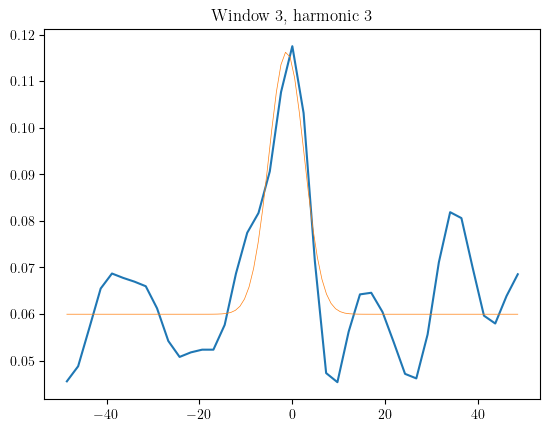

4 & 1 & 0.583 & 0.891 & 3.918 \\


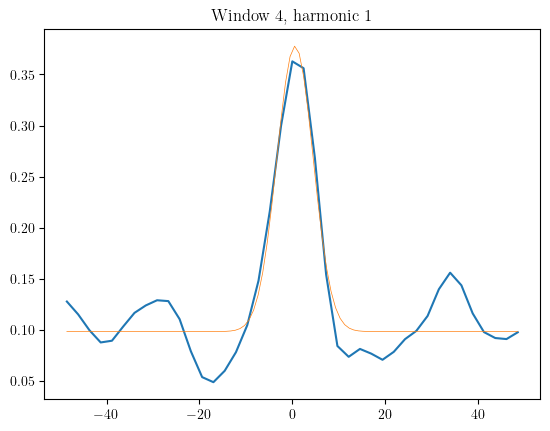

4 & 2 & -0.363 & 0.902 & 4.232 \\


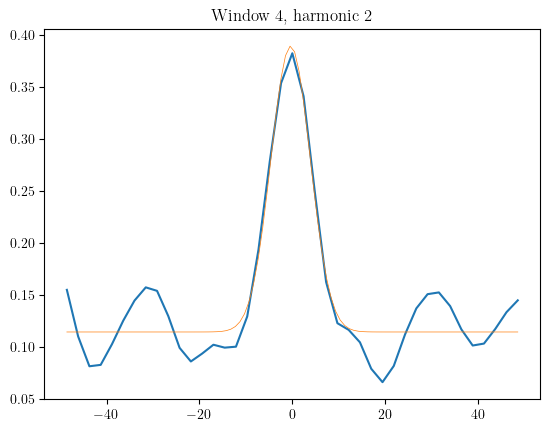

4 & 3 & -0.114 & 0.831 & 4.264 \\


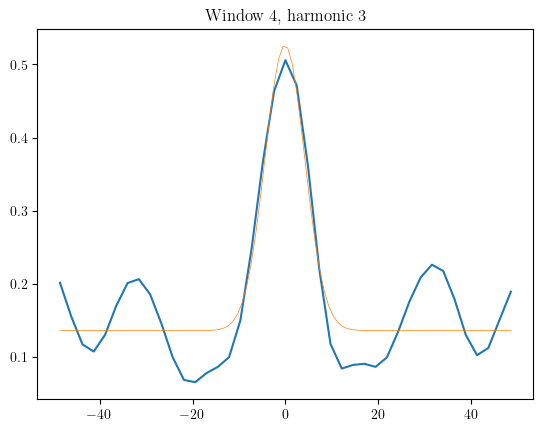

5 & 1 & -1.57 & 0.347 & 2.44 \\


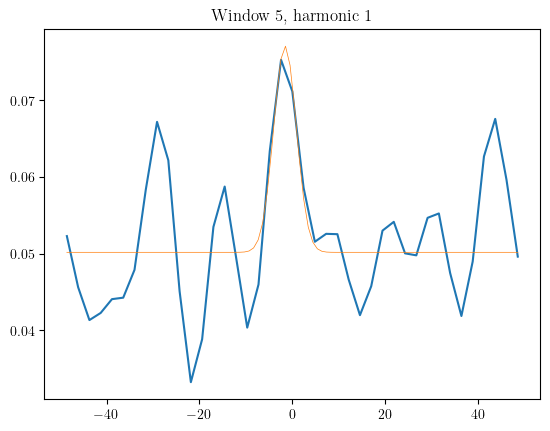

5 & 2 & 0.719 & 0.572 & 2.569 \\


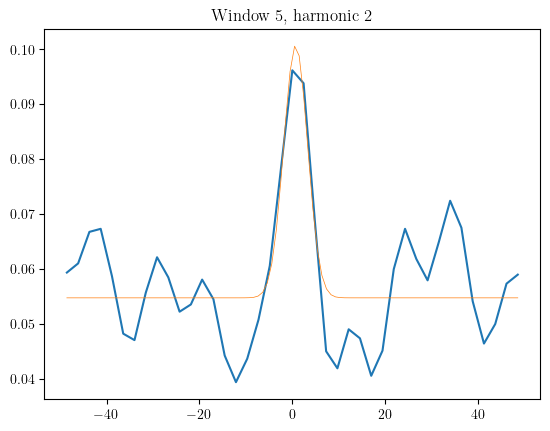

5 & 3 & 0.065 & 0.549 & 2.565 \\


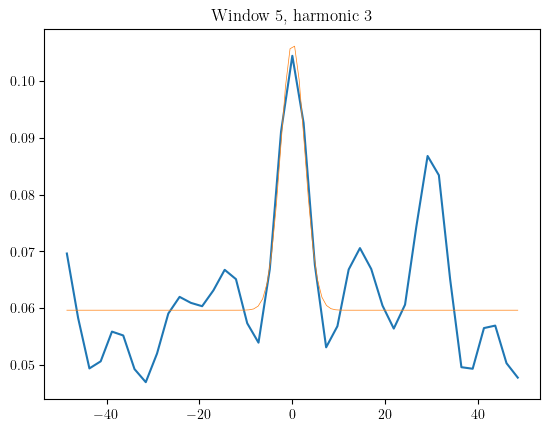

In [87]:
for i in range(len(manuals)):
    centre_R, centre_Z = get_magnetic_centre(equilib_time, equilib_R, equilib_Z, equilib_psi, manuals[i])
    coilpos_angles = np.arctan((centre_Z-coilpos[:,1])/(centre_R-coilpos[:,0]))
    f_arr, k_arr, kf_matrix = get_kf_spec_mirnov(mirnov_time, mirnov_data, coilpos_angles, manuals[i])
    
    f_arr = f_arr[(np.abs(f_arr - 0.0)).argmin():]
    fit_go = 0 # default: 15
    fit_stop = len(k_arr) # default: 26
    
    for h in range(3):
        f_start = (np.abs(f_arr - harmonic_freqs[i,h,0])).argmin()
        f_stop = (np.abs(f_arr - harmonic_freqs[i,h,1])).argmin()
        profile = np.sum(np.abs(kf_matrix[f_start:f_stop+1,:])**2,axis=0)
        plt.plot(k_arr[fit_go:fit_stop], profile[fit_go:fit_stop])
        plt.title("Window " + str(i+1) + ", harmonic " + str(h+1))
        
        popt, pcov = curve_fit(gaussian, k_arr[fit_go:fit_stop], profile[fit_go:fit_stop])
        residuals = profile[fit_go:fit_stop] - gaussian(k_arr[fit_go:fit_stop], *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((profile[fit_go:fit_stop] - np.mean(profile[fit_go:fit_stop]))**2)
        r_squared = 1 - (ss_res / ss_tot)
        fit_x = np.linspace(k_arr[fit_go], k_arr[fit_stop-1], 100)
        fit_y = gaussian(fit_x, *popt)
        print(i+1, "&", h+1, "&", str(np.round(popt[1],3)), "&", str(np.round(r_squared,3)), "&", str(np.round(popt[2],3)) , 2*chr(92))
        #print(popt)
        plt.plot(fit_x, fit_y, linewidth=0.5)
        
        plt.show()
        plt.close()

## Region 2 focus

    1) Choose windows of time just before the crashes that contain interesting features.<br />
    2) Plot dispersion relations to look at harmonics in more detail.<br />
    3) Select frequency ranges to sum to generate mode number profile.<br />
    4) Generate the mode number profiles, apply a Gaussian fit to find the central peak.

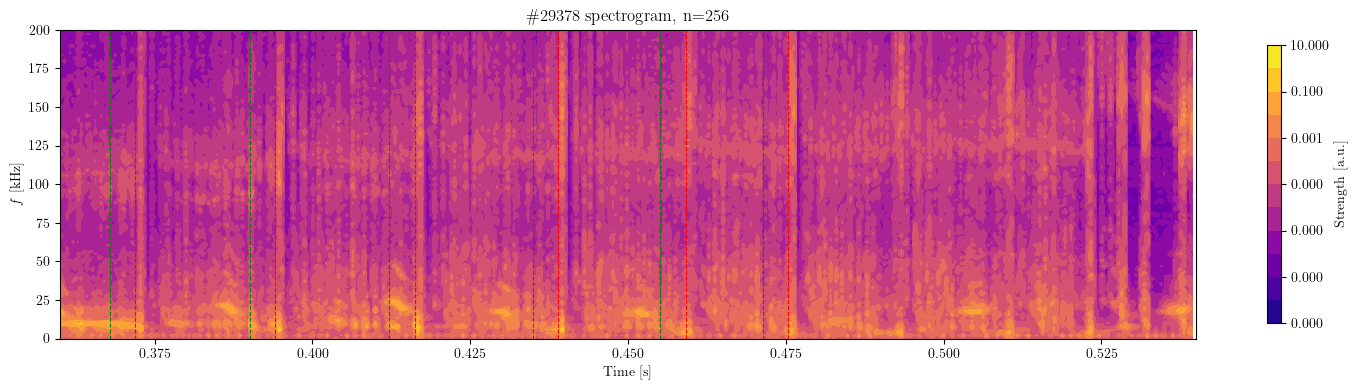

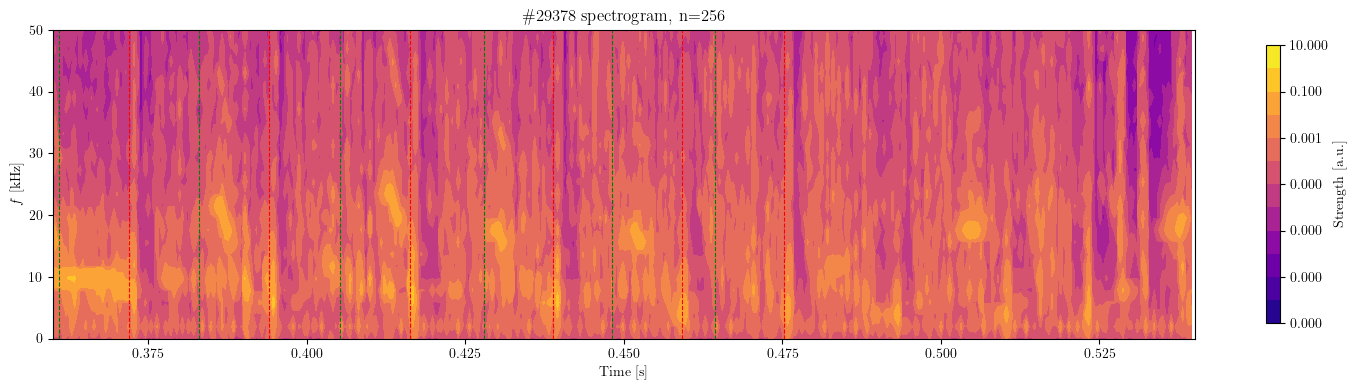

In [15]:
sum_mirnov_fluct_spectrogram(shot, mirnov_time, mirnov_data, regions[1], n=8, vlines=pre_crash_windows[1], plot=True)
pcw2 = get_crash_adjacent_window(utda_time, utda_data, thresholds[1], regions[1], start_shift=12e-3, end_shift=1e-3)
_=sum_mirnov_fluct_spectrogram(shot, mirnov_time, mirnov_data, regions[1], n=8, vlines=pcw2, freq_lims=[0.0,50.0], plot=True)

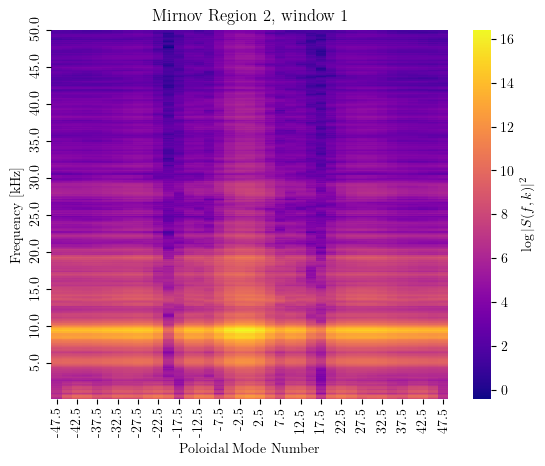

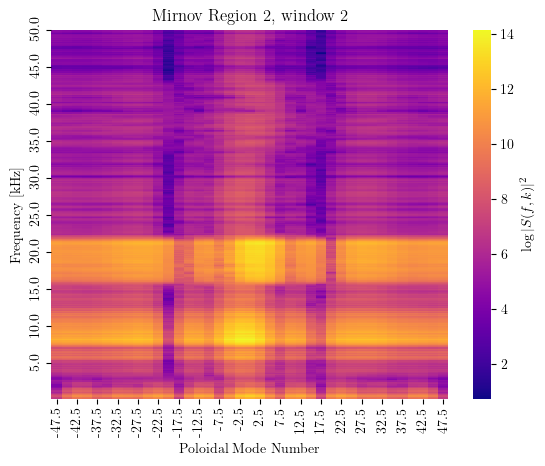

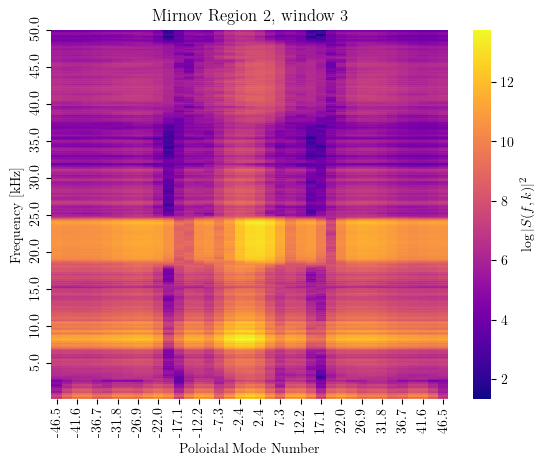

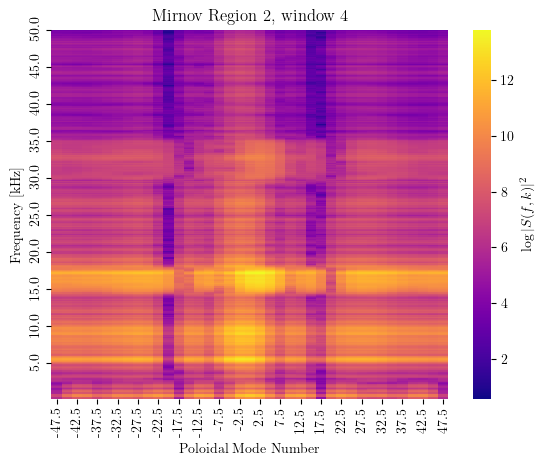

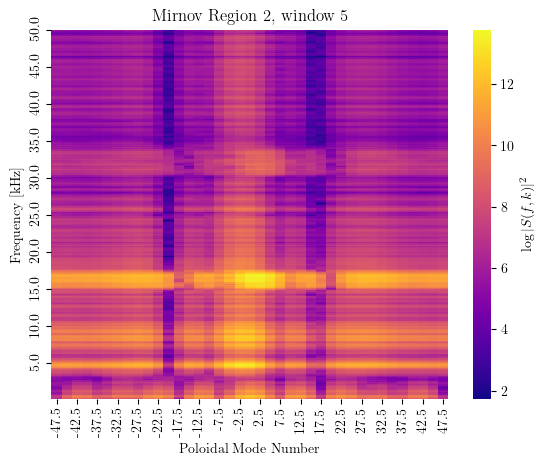

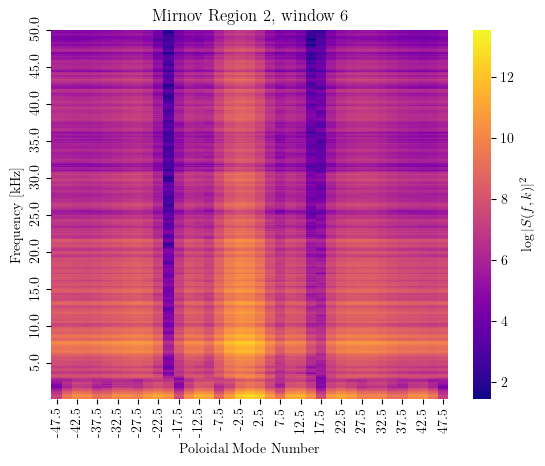

In [17]:
for i in range(len(pcw2)):
    centre_R, centre_Z = get_magnetic_centre(equilib_time, equilib_R, equilib_Z, equilib_psi, pcw2[i])
    coilpos_angles = np.arctan((centre_Z-coilpos[:,1])/(centre_R-coilpos[:,0]))

    f_arr, k_arr, kf_matrix = get_kf_spec_mirnov(mirnov_time, mirnov_data, coilpos_angles, pcw2[i])
    plot_kf_spec_mirnov(f_arr, k_arr, kf_matrix, "Mirnov region 2, window " + str(i+1), fint=5.0e3, fmin=0.0, fmax=50.0e3, smooth_pts=5, conditional=False, save=False)

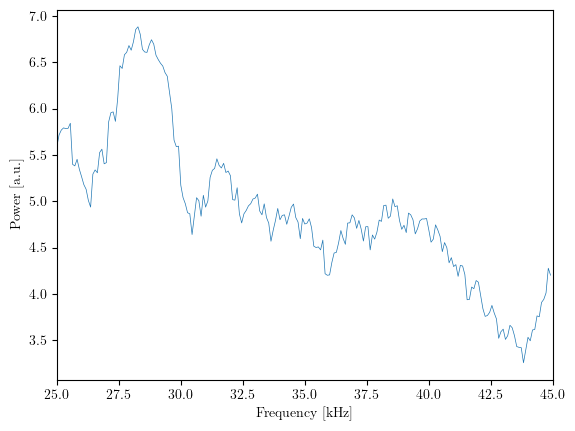

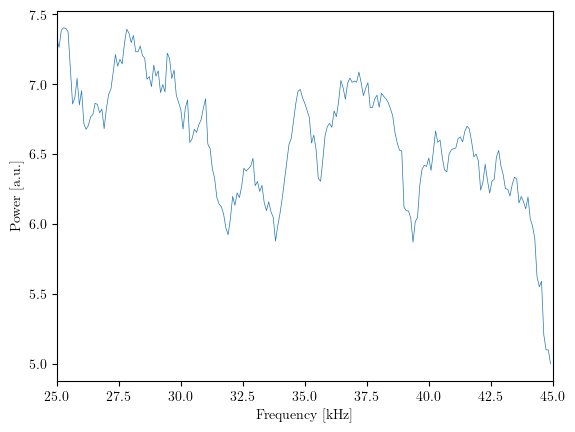

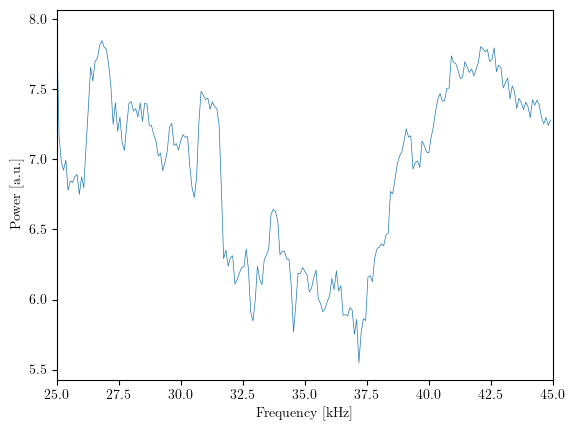

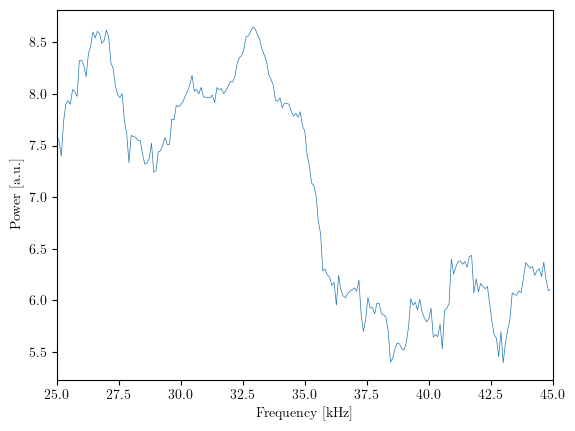

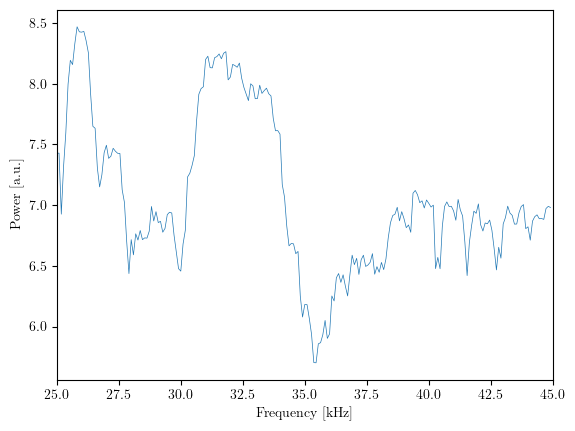

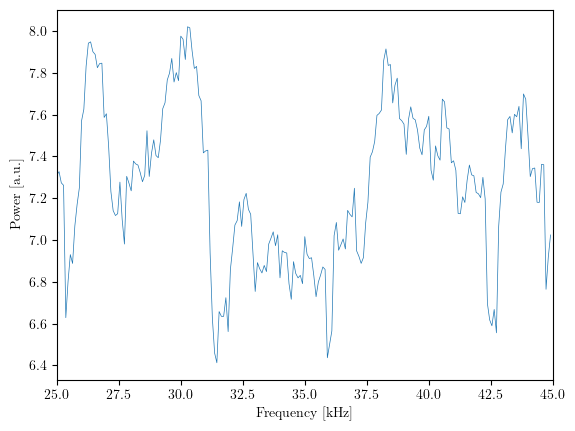

In [76]:
for window in pcw2:
    get_mirnov_ksum(equilib_time, equilib_R, equilib_Z, equilib_psi, mirnov_time, mirnov_data, 25e3, 45e3, window)

In [77]:
reg2_harmonics = np.asarray([
    [[7.0, 11.0], [16.0, 20.0], [27.0,30.0]],
    [[7.5, 12.0], [16.0, 22.0], [37.0, 43.0]],
    [[7.0, 11.0], [19.0, 24.0], [38.0, 47.0]],
    [[7.5, 10.0], [14.0, 19.0], [30.0, 35.0]],
    [[7.0, 10.5], [15.0, 17.5], [30.0, 35.0]]
])*1.0e3

In [78]:
reg2_mode_numbers = []
for i in range(len(pcw2)-1):
    centre_R, centre_Z = get_magnetic_centre(equilib_time, equilib_R, equilib_Z, equilib_psi, pcw2[i])
    coilpos_angles = np.arctan((centre_Z-coilpos[:,1])/(centre_R-coilpos[:,0]))
    f_arr, k_arr, kf_matrix = get_kf_spec_mirnov(mirnov_time, mirnov_data, coilpos_angles, pcw2[i])
    
    f_arr = f_arr[(np.abs(f_arr - 0.0)).argmin():]
    fit_go = 11 # default: 11
    fit_stop = 29# default: 29
    this_window = []
    
    for h in range(3):
        f_start = (np.abs(f_arr - reg2_harmonics[i,h,0])).argmin()
        f_stop = (np.abs(f_arr - reg2_harmonics[i,h,1])).argmin()
        profile = np.sum(np.abs(kf_matrix[f_start:f_stop+1,:])**2,axis=0)
        plt.plot(k_arr[fit_go:fit_stop], profile[fit_go:fit_stop])
        plt.title("Region 2, window " + str(i+1) + ", harmonic " + str(h+1))
        
        popt, pcov = curve_fit(gaussian, k_arr[fit_go:fit_stop], profile[fit_go:fit_stop])
        residuals = profile[fit_go:fit_stop] - gaussian(k_arr[fit_go:fit_stop], *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((profile[fit_go:fit_stop] - np.mean(profile[fit_go:fit_stop]))**2)
        r_squared = 1 - (ss_res / ss_tot)
        fit_x = np.linspace(k_arr[fit_go], k_arr[fit_stop-1], 100)
        fit_y = gaussian(fit_x, *popt)
        this_window.append(popt[1])
        print(i+1, "&", h+1, "&", str(np.round(popt[1],3)), "&", str(np.round(r_squared,3)), "&", str(np.round(popt[2],3)) , 2*chr(92))
        plt.plot(fit_x, fit_y, linewidth=0.5)
        
        #plt.show()
        plt.close()
    reg2_mode_numbers.append(this_window)

1 & 1 & 0.039 & 0.96 & 4.138 \\
1 & 2 & 0.05 & 0.99 & 4.008 \\
1 & 3 & 1.211 & 0.994 & 4.702 \\
2 & 1 & 1.533 & 0.997 & 4.15 \\
2 & 2 & 2.666 & 0.991 & 3.971 \\
2 & 3 & 1.604 & 0.991 & 3.999 \\
3 & 1 & 1.86 & 0.872 & 6.046 \\
3 & 2 & 2.567 & 0.948 & 5.107 \\
3 & 3 & 1.853 & 0.966 & -3.84 \\
4 & 1 & 1.33 & 0.866 & 6.376 \\
4 & 2 & 3.231 & 0.88 & 4.215 \\
4 & 3 & 2.787 & 0.954 & -3.729 \\
5 & 1 & 2.31 & 0.884 & 5.985 \\
5 & 2 & 0.437 & 0.952 & 5.918 \\
5 & 3 & 2.447 & 0.968 & 3.983 \\


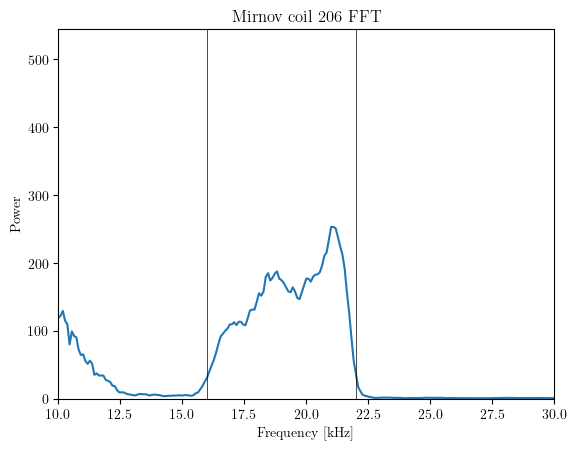

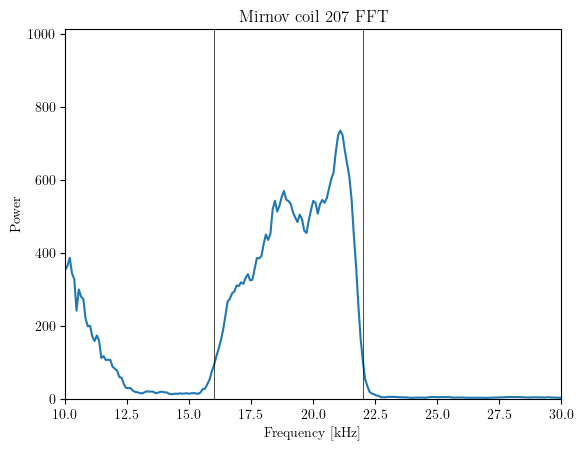

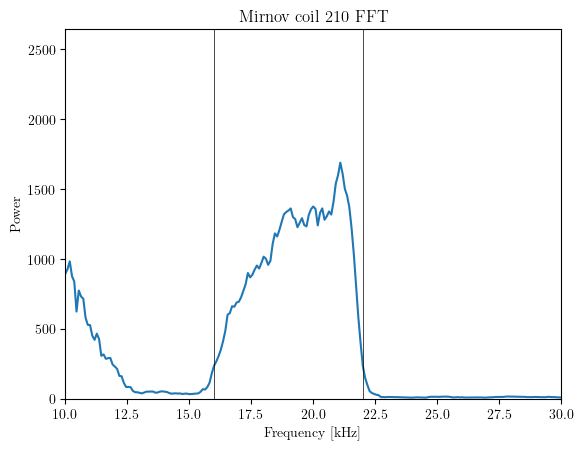

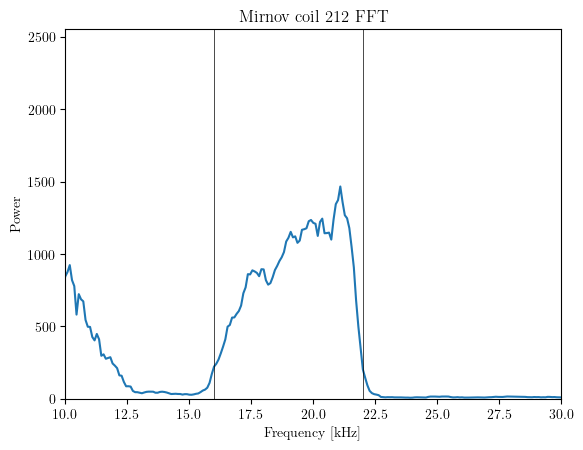

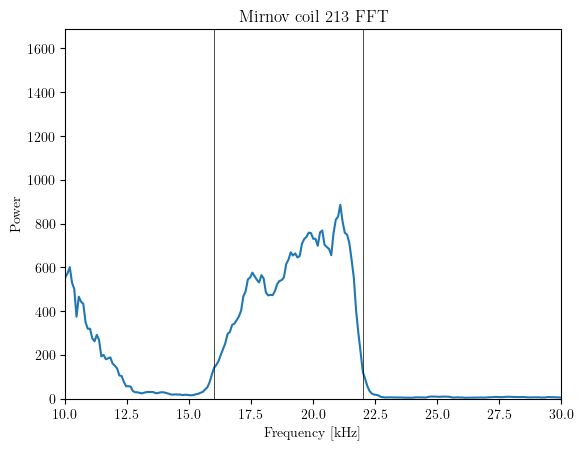

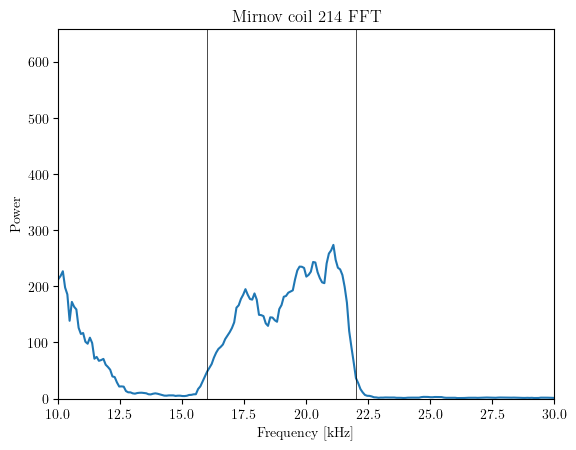

In [81]:
mareas = []
for coil in range(6):
    freqs, coeffs = fft_channel(mirnov_time, mirnov_data, coil, pcw2[1])
    coeffs_sum = np.abs(coeffs)**2

    fig, ax = plt.subplots()
    ax.plot(freqs*1e-3, smooth((np.abs(coeffs_sum)),10))
    ax.set_xlim(left=10, right=30)
    ax.set_xlabel("Frequency [kHz]")
    ax.set_ylim(bottom=0)
    ax.set_ylabel("Power")
    ax.set_title("Mirnov coil " + str(coil_nums[coil]) + " FFT")

    limits = reg2_harmonics[1,1]*1e-3
    ax.vlines(limits[0], ax.get_ylim()[0], ax.get_ylim()[1], "k", linewidth=0.5)
    ax.vlines(limits[1], ax.get_ylim()[0], ax.get_ylim()[1], "k", linewidth=0.5)
    plt.show()
        
    idx1 = (np.abs(freqs*1e-3 - limits[0])).argmin()
    idx2 = (np.abs(freqs*1e-3 - limits[1])).argmin()
    full = trapz(coeffs_sum[idx1:idx2+1], freqs[idx1:idx2+1])
    noise = trapz([coeffs_sum[idx1], coeffs_sum[idx2]], [freqs[idx1], freqs[idx2]])
    mareas.append(full-noise)

In [88]:
mareas/max(mareas)

array([0.1330322 , 0.40518548, 1.        , 0.84082147, 0.47995162,
       0.12031346])